In [1]:
import logging, os
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pickle as pkl
import pandas as pd
from numpy.random import RandomState
rng = RandomState(93748573)
from pprint import pprint

In [3]:
from gensim import models
from gensim.corpora import Dictionary
# Use coherence model to measure the LDA models generated
from gensim.models.coherencemodel import CoherenceModel

2018-02-06 12:35:02,835 : INFO : 'pattern' package not found; tag filters are not available for English


In [4]:
# ref: http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/Gensim%20Newsgroup.ipynb
import pyLDAvis.gensim as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()
from IPython.display import HTML

# Topic Modelling on [data_schoolofinf](../../data/data_schoolofinf)

In [5]:
DATA_DIR = '../../data/data_schoolofinf/'

## toks

In [10]:
# Import the dataset:
df_combined_toks = pd.read_pickle(os.path.join(DATA_DIR,'toks', 'toks.combined.pkl'))
df_combined_toks.head(3)

year  \
pub_id                                       
400818dc-63af-4a26-80c5-906f98e1f8ab  1989   
18b1a861-afef-4fff-bc80-d02e05be18c4  2013   
309fdbfc-227b-4588-9264-f0f4e3cadfcb  1994   

                                                                            toks_metada  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab  [ballooning, stability, analysis, jet, hmode, ...   
18b1a861-afef-4fff-bc80-d02e05be18c4  [query, processing, data, integration, chapter...   
309fdbfc-227b-4588-9264-f0f4e3cadfcb  [comprehension, syntax, syntax, comprehension,...   

                                                                           toks_pdf2txt  
pub_id                                                                                   
400818dc-63af-4a26-80c5-906f98e1f8ab                                                     
18b1a861-afef-4fff-bc80-d02e05be18c4                                                     
309fdbfc-227b-4588-9264-f0f4e3cadfcb  [comprehension, syntax, citation, published, v...

In [26]:
df_combined_toks = df_combined_toks.drop(
    df_combined_toks[(df_combined_toks.year < 1997) | (df_combined_toks.year > 2017)].index)
df_combined_toks[
    'toks_pdf2txt'] = df_combined_toks.toks_pdf2txt.apply(
        lambda x: [] if not len(x) else x)
df_combined_toks[
    'toks_metada'] = df_combined_toks.toks_metada.apply(
        lambda x: [] if not len(x) else x)

## Hyper-parameters for LDA

Creates the topic model using the corpus, dictionary and index created.

- Iterations :: number of times each documents is seen in the E-step in online learning
- passes     :: number of times the corpus is seen

In [14]:
passes = 30  # total number of times the corpus is seen
iterations = 1000  # how many times each document is seen
chunksize = 2000  # how many documents each mini-batch
update_every = 0  # Batch learning
eval_every = None

# Model 1: metadata + pdf 1997-2017

In [41]:
dict_all = Dictionary.load(os.path.join(DATA_DIR,'corpora','dictionary.all'))

2018-02-05 19:09:38,491 : INFO : loading Dictionary object from ../../data/data_schoolofinf/corpora/dictionary.all
2018-02-05 19:09:38,536 : INFO : loaded ../../data/data_schoolofinf/corpora/dictionary.all


In [43]:
df_all = df_combined_toks.copy()
df_all['concat_toks'] = df_combined_toks.apply(
    lambda row: row.toks_metada + row.toks_pdf2txt, axis=1)
# Create a bow tagging for each publication:
df_all['bow'] = df_all['concat_toks'].apply(dict_all.doc2bow)

# Generate a corpus based on the tokens, which we will be using later
corpus_all = df_all.bow.tolist()

In [45]:
# Parameters FOR LDA:
num_topics = 35 ### SEE THE R-notebook
corpus = corpus_all
tmp = dict_all[0]
id2word = dict_all.id2token

In [47]:
# This is the fullpub LDA model.
lda_all = models.ldamodel.LdaModel(
    minimum_probability=.9,
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    eta='auto',
    alpha='auto',
    num_topics=num_topics,
    iterations=iterations,
    passes=passes,
    update_every=update_every,
    eval_every=eval_every,
    random_state=rng)

2018-02-05 19:12:29,766 : INFO : using autotuned alpha, starting with [0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857]
2018-02-05 19:12:29,783 : INFO : using serial LDA version on this node
2018-02-05 19:12:54,230 : INFO : running batch LDA training, 35 topics, 30 passes over the supplied corpus of 8028 document

2018-02-05 19:22:44,415 : INFO : PROGRESS: pass 1, at document #6000/8028
2018-02-05 19:23:29,471 : INFO : optimized alpha [0.016579315719985624, 0.02045323410713541, 0.018169532968721615, 0.02094310620341128, 0.014430656192574996, 0.024418693209371917, 0.013979067803162354, 0.022076238074432895, 0.016718953392823317, 0.014709699278675943, 0.02074585241852996, 0.016685606798438724, 0.015560179577980792, 0.017516322291330027, 0.015192101604453187, 0.024816214046785256, 0.017308541733735014, 0.01810924431269246, 0.016885311006731338, 0.019475231876729573, 0.015586466169023365, 0.01726202491801297, 0.025228058702031837, 0.014827019486527346, 0.01858668317058457, 0.018736903442507336, 0.017023298149211424, 0.013375069120825471, 0.014660776803440035, 0.017957785207642667, 0.013548973054952817, 0.015093346735982158, 0.020662916677839302, 0.017214337725807036, 0.016178251651527767]
2018-02-05 19:23:29,482 : INFO : PROGRESS: pass 1, at document #8000/8028
2018-02-05 19:24:14,052 : INFO : optim

2018-02-05 19:26:51,557 : INFO : topic #23 (0.012): 0.014*"cid" + 0.006*"we" + 0.006*"translation" + 0.005*"word" + 0.004*"language" + 0.004*"phrase" + 0.003*"rule" + 0.003*"al" + 0.003*"machine" + 0.003*"number"
2018-02-05 19:26:51,558 : INFO : topic #17 (0.020): 0.006*"application" + 0.004*"we" + 0.004*"this" + 0.003*"state" + 0.003*"execution" + 0.003*"performance" + 0.003*"cid" + 0.003*"core" + 0.003*"example" + 0.003*"level"
2018-02-05 19:26:51,560 : INFO : topic #15 (0.020): 0.009*"cid" + 0.005*"al" + 0.005*"feature" + 0.005*"et" + 0.004*"we" + 0.004*"rule" + 0.004*"et_al" + 0.003*"action" + 0.003*"this" + 0.003*"method"
2018-02-05 19:26:51,562 : INFO : topic #3 (0.022): 0.009*"cid" + 0.005*"de" + 0.004*"proof" + 0.004*"we" + 0.004*"state" + 0.003*"explorer" + 0.003*"category" + 0.003*"process" + 0.003*"pepa" + 0.003*"language"
2018-02-05 19:26:51,566 : INFO : topic diff=1.062584, rho=0.377587
2018-02-05 19:26:55,180 : INFO : PROGRESS: pass 3, at document #2000/8028
2018-02-05 19

2018-02-05 19:29:53,542 : INFO : PROGRESS: pass 4, at document #6000/8028
2018-02-05 19:30:20,681 : INFO : optimized alpha [0.011349734542363283, 0.01572719752141944, 0.018890766959553325, 0.02155129678403404, 0.0116534176572478, 0.015279776537580858, 0.012369124986475312, 0.018317900758770676, 0.01262212413666052, 0.013599301089805838, 0.0137265912261004, 0.016688055826752406, 0.010550039782397417, 0.01922889988003751, 0.017687480723005224, 0.016745787683669185, 0.01586332237947667, 0.0236600636315915, 0.013386434075501694, 0.016774534640844014, 0.014398230936488515, 0.012090760634195718, 0.0159394138543505, 0.010448164915240532, 0.02268055819680993, 0.015263552851065098, 0.016086351582687213, 0.01191015093587423, 0.013998296216928214, 0.01634621789584111, 0.01005080830460568, 0.011461001487223666, 0.013225462249146036, 0.014228970067861672, 0.014985806834077466]
2018-02-05 19:30:20,691 : INFO : PROGRESS: pass 4, at document #8000/8028
2018-02-05 19:30:46,933 : INFO : optimized alpha 

2018-02-05 19:32:44,405 : INFO : topic #30 (0.009): 0.017*"transition" + 0.013*"net" + 0.013*"token" + 0.012*"cost" + 0.008*"place" + 0.007*"petri" + 0.007*"state" + 0.007*"we" + 0.006*"petri_net" + 0.005*"marking"
2018-02-05 19:32:44,407 : INFO : topic #23 (0.009): 0.009*"translation" + 0.009*"cid" + 0.008*"word" + 0.007*"we" + 0.006*"rule" + 0.006*"phrase" + 0.004*"language" + 0.004*"al" + 0.003*"pair" + 0.003*"machine"
2018-02-05 19:32:44,408 : INFO : topic #3 (0.023): 0.006*"cid" + 0.005*"de" + 0.004*"category" + 0.004*"explorer" + 0.004*"pepa" + 0.004*"state" + 0.004*"process" + 0.003*"publication" + 0.003*"pp" + 0.003*"proof"
2018-02-05 19:32:44,410 : INFO : topic #24 (0.026): 0.005*"information" + 0.003*"social" + 0.003*"this" + 0.003*"study" + 0.003*"human" + 0.003*"dialogue" + 0.003*"may" + 0.003*"student" + 0.003*"group" + 0.002*"language"
2018-02-05 19:32:44,411 : INFO : topic #17 (0.027): 0.007*"application" + 0.004*"performance" + 0.004*"execution" + 0.004*"this" + 0.004*"

2018-02-05 19:35:23,117 : INFO : PROGRESS: pass 7, at document #6000/8028
2018-02-05 19:35:46,260 : INFO : optimized alpha [0.00942076287452629, 0.014210488314931987, 0.02176984194673518, 0.0225035932659518, 0.010203978250239006, 0.012977683017785097, 0.01229075422119043, 0.017593212223693547, 0.011732372886135248, 0.013379038025033051, 0.011749522461034022, 0.016819606171548575, 0.009463827828068724, 0.02073377958617972, 0.02110272969014657, 0.014367284198611564, 0.015704518956206642, 0.029674459478751507, 0.01182878847422643, 0.016942080964558258, 0.014702932242070274, 0.010313750304825337, 0.013741881727868686, 0.008791168662788167, 0.02996919941018476, 0.01452025216896105, 0.01566667009345994, 0.011558749019885982, 0.014562130553472738, 0.017494219005775323, 0.008739132998692742, 0.009964003272771626, 0.011046932322734142, 0.012696735835030176, 0.014940679563111795]
2018-02-05 19:35:46,271 : INFO : PROGRESS: pass 7, at document #8000/8028
2018-02-05 19:36:09,284 : INFO : optimized 

2018-02-05 19:37:53,924 : INFO : topic #23 (0.008): 0.011*"translation" + 0.009*"word" + 0.008*"rule" + 0.007*"we" + 0.007*"phrase" + 0.006*"cid" + 0.004*"language" + 0.004*"membrane" + 0.004*"pair" + 0.004*"machine"
2018-02-05 19:37:53,929 : INFO : topic #30 (0.008): 0.021*"transition" + 0.016*"net" + 0.013*"cost" + 0.013*"token" + 0.009*"place" + 0.009*"state" + 0.008*"petri" + 0.007*"we" + 0.007*"petri_net" + 0.006*"marking"
2018-02-05 19:37:53,931 : INFO : topic #3 (0.024): 0.006*"de" + 0.005*"cid" + 0.005*"explorer" + 0.005*"category" + 0.004*"pp" + 0.004*"publication" + 0.004*"copyright" + 0.004*"process" + 0.003*"state" + 0.003*"computational"
2018-02-05 19:37:53,932 : INFO : topic #17 (0.033): 0.008*"application" + 0.005*"performance" + 0.005*"execution" + 0.004*"code" + 0.004*"service" + 0.004*"this" + 0.003*"program" + 0.003*"software" + 0.003*"resource" + 0.003*"we"
2018-02-05 19:37:53,934 : INFO : topic #24 (0.034): 0.005*"information" + 0.004*"social" + 0.003*"this" + 0.00

2018-02-05 19:40:14,587 : INFO : PROGRESS: pass 10, at document #6000/8028
2018-02-05 19:40:36,753 : INFO : optimized alpha [0.008596179739041306, 0.01397022876088634, 0.02459060531236105, 0.02431436806486645, 0.009538683420354148, 0.0122978646751276, 0.012549675911665501, 0.01774550449300818, 0.011812862159381918, 0.013618225037582242, 0.011018813718709105, 0.017049973330709116, 0.010185437126036258, 0.021231104372932276, 0.023149320486565737, 0.013691089220656032, 0.01587869934888963, 0.03509470310159145, 0.011121906559473243, 0.017865530962377807, 0.015493937418746991, 0.009584724700700842, 0.013402431738148203, 0.00806449265177617, 0.03718875109807983, 0.015179453277491393, 0.015324253079314338, 0.012023858987746803, 0.015660042945342376, 0.01953008113633561, 0.008167084490126302, 0.009335270817604829, 0.010362557859097444, 0.012182462098042779, 0.015236905623542669]
2018-02-05 19:40:36,762 : INFO : PROGRESS: pass 10, at document #8000/8028
2018-02-05 19:40:57,907 : INFO : optimize

2018-02-05 19:42:35,700 : INFO : topic #30 (0.008): 0.024*"transition" + 0.017*"net" + 0.014*"cost" + 0.013*"token" + 0.010*"state" + 0.009*"place" + 0.008*"petri" + 0.007*"we" + 0.007*"petri_net" + 0.006*"conﬁguration"
2018-02-05 19:42:35,702 : INFO : topic #23 (0.008): 0.011*"translation" + 0.009*"rule" + 0.009*"word" + 0.007*"phrase" + 0.007*"we" + 0.005*"membrane" + 0.004*"language" + 0.004*"pair" + 0.004*"cid" + 0.004*"bx"
2018-02-05 19:42:35,704 : INFO : topic #2 (0.026): 0.010*"feature" + 0.009*"learning" + 0.007*"training" + 0.007*"method" + 0.006*"network" + 0.006*"we" + 0.005*"parameter" + 0.004*"number" + 0.004*"function" + 0.004*"performance"
2018-02-05 19:42:35,705 : INFO : topic #17 (0.037): 0.008*"application" + 0.005*"performance" + 0.005*"execution" + 0.005*"code" + 0.004*"service" + 0.004*"this" + 0.004*"program" + 0.004*"software" + 0.004*"resource" + 0.003*"level"
2018-02-05 19:42:35,706 : INFO : topic #24 (0.041): 0.006*"information" + 0.004*"social" + 0.003*"this"

2018-02-05 19:44:51,509 : INFO : PROGRESS: pass 13, at document #6000/8028
2018-02-05 19:45:12,447 : INFO : optimized alpha [0.00842902141067538, 0.01403628266066042, 0.026828723834823102, 0.0257220852582909, 0.009392462002496002, 0.012206485265485258, 0.012876799072514458, 0.018411417430367564, 0.012245835341202417, 0.014066295620212188, 0.010786604287998039, 0.017422797483095276, 0.011835686417784019, 0.022161909334764526, 0.024713792377914063, 0.013383211823732356, 0.016012670380906282, 0.03793090963707221, 0.010785472536324779, 0.019365371352466274, 0.01612078432819054, 0.009330464158359619, 0.013685166944859445, 0.007946461802964511, 0.044181618275467655, 0.0161845101467311, 0.015078125577433264, 0.012588418623652913, 0.01715084877637853, 0.022012333281757945, 0.007940749860959022, 0.009081330414463759, 0.010562987118937644, 0.012212451526711477, 0.015666702972425506]
2018-02-05 19:45:12,457 : INFO : PROGRESS: pass 13, at document #8000/8028
2018-02-05 19:45:33,973 : INFO : optimi

2018-02-05 19:47:07,195 : INFO : topic #30 (0.008): 0.026*"transition" + 0.017*"net" + 0.013*"cost" + 0.013*"token" + 0.011*"state" + 0.009*"place" + 0.008*"petri" + 0.008*"we" + 0.007*"conﬁguration" + 0.007*"petri_net"
2018-02-05 19:47:07,196 : INFO : topic #23 (0.008): 0.012*"translation" + 0.010*"rule" + 0.009*"word" + 0.007*"phrase" + 0.007*"we" + 0.005*"membrane" + 0.005*"pair" + 0.004*"language" + 0.004*"bx" + 0.004*"number"
2018-02-05 19:47:07,198 : INFO : topic #2 (0.028): 0.009*"feature" + 0.009*"learning" + 0.007*"method" + 0.007*"training" + 0.006*"we" + 0.006*"network" + 0.005*"parameter" + 0.004*"function" + 0.004*"number" + 0.004*"distribution"
2018-02-05 19:47:07,199 : INFO : topic #17 (0.039): 0.008*"application" + 0.005*"performance" + 0.005*"code" + 0.005*"execution" + 0.004*"service" + 0.004*"program" + 0.004*"this" + 0.004*"software" + 0.004*"resource" + 0.003*"level"
2018-02-05 19:47:07,201 : INFO : topic #24 (0.048): 0.006*"information" + 0.004*"social" + 0.003*"t

2018-02-05 19:49:20,673 : INFO : PROGRESS: pass 16, at document #6000/8028
2018-02-05 19:49:41,693 : INFO : optimized alpha [0.00846614556224808, 0.014120592059305884, 0.028742350961909892, 0.027084922196520023, 0.009465766404389593, 0.01277873054840709, 0.013237885219687662, 0.01959371898629555, 0.012734701186098098, 0.014526646772083568, 0.010804281415812862, 0.017878451456768876, 0.013770172767437083, 0.022721553141751102, 0.025860036523366374, 0.01372380803607178, 0.01623002650116881, 0.03997445994041003, 0.010691516484723926, 0.020924443458604777, 0.016701543899727514, 0.009295844327790013, 0.01401804054398478, 0.008129308629943792, 0.050062726322743605, 0.017279380824236863, 0.014974012188131597, 0.013134497976829284, 0.019250981014863944, 0.024722928576959118, 0.008001209101688266, 0.009027721420822764, 0.011153572978999661, 0.012229487765623175, 0.016184629805119775]
2018-02-05 19:49:41,700 : INFO : PROGRESS: pass 16, at document #8000/8028
2018-02-05 19:50:03,021 : INFO : opti

2018-02-05 19:51:32,935 : INFO : topic #30 (0.008): 0.027*"transition" + 0.016*"net" + 0.013*"cost" + 0.013*"state" + 0.012*"token" + 0.009*"place" + 0.008*"conﬁguration" + 0.008*"we" + 0.007*"petri" + 0.006*"petri_net"
2018-02-05 19:51:32,937 : INFO : topic #23 (0.008): 0.012*"translation" + 0.011*"rule" + 0.009*"word" + 0.007*"phrase" + 0.007*"we" + 0.005*"membrane" + 0.005*"pair" + 0.004*"language" + 0.004*"bx" + 0.004*"number"
2018-02-05 19:51:32,938 : INFO : topic #2 (0.030): 0.009*"learning" + 0.009*"feature" + 0.008*"method" + 0.007*"training" + 0.006*"we" + 0.005*"network" + 0.005*"parameter" + 0.004*"function" + 0.004*"distribution" + 0.004*"algorithm"
2018-02-05 19:51:32,940 : INFO : topic #17 (0.041): 0.008*"application" + 0.006*"performance" + 0.005*"code" + 0.005*"execution" + 0.005*"service" + 0.004*"program" + 0.004*"this" + 0.004*"resource" + 0.004*"software" + 0.004*"level"
2018-02-05 19:51:32,941 : INFO : topic #24 (0.053): 0.006*"information" + 0.004*"social" + 0.003

2018-02-05 19:53:44,491 : INFO : PROGRESS: pass 19, at document #6000/8028
2018-02-05 19:54:05,554 : INFO : optimized alpha [0.008604935434720561, 0.014392411326467881, 0.03040919342541042, 0.02845743434788824, 0.009591489058142968, 0.013460019815428392, 0.013619469470006152, 0.020860347901101826, 0.013267235543708957, 0.014958391006750347, 0.01093360170443141, 0.018776661573178317, 0.015897381217263876, 0.023621493916445184, 0.02664308477889474, 0.014037187042716883, 0.0164602466141535, 0.04166546877327662, 0.010741588222410512, 0.02222677700333059, 0.01729667537058318, 0.009336555554583145, 0.014450238336526993, 0.00841673206456242, 0.054006432669526656, 0.018394056173686047, 0.014965139176479151, 0.013659577404172108, 0.021481065179750763, 0.027636312895469507, 0.00819580460749921, 0.009082001876240264, 0.011932272612688059, 0.012176158313402175, 0.016729782621667518]
2018-02-05 19:54:05,564 : INFO : PROGRESS: pass 19, at document #8000/8028
2018-02-05 19:54:25,709 : INFO : optimize

2018-02-05 19:55:59,375 : INFO : topic #30 (0.008): 0.028*"transition" + 0.016*"net" + 0.014*"state" + 0.013*"cost" + 0.012*"token" + 0.009*"place" + 0.008*"conﬁguration" + 0.008*"we" + 0.007*"petri" + 0.007*"ﬁnite"
2018-02-05 19:55:59,377 : INFO : topic #23 (0.009): 0.012*"translation" + 0.011*"rule" + 0.009*"word" + 0.007*"phrase" + 0.007*"we" + 0.005*"membrane" + 0.005*"pair" + 0.004*"language" + 0.004*"bx" + 0.004*"number"
2018-02-05 19:55:59,378 : INFO : topic #2 (0.031): 0.010*"learning" + 0.008*"feature" + 0.008*"method" + 0.007*"training" + 0.006*"we" + 0.005*"parameter" + 0.005*"network" + 0.004*"function" + 0.004*"algorithm" + 0.004*"distribution"
2018-02-05 19:55:59,380 : INFO : topic #17 (0.043): 0.008*"application" + 0.006*"performance" + 0.006*"code" + 0.005*"execution" + 0.005*"service" + 0.004*"program" + 0.004*"this" + 0.004*"resource" + 0.004*"software" + 0.004*"level"
2018-02-05 19:55:59,381 : INFO : topic #24 (0.056): 0.006*"information" + 0.004*"social" + 0.004*"we

2018-02-05 19:58:13,088 : INFO : PROGRESS: pass 22, at document #6000/8028
2018-02-05 19:58:33,689 : INFO : optimized alpha [0.008808970689741784, 0.014754280345698279, 0.03180812672465103, 0.030108995115218133, 0.009737208278572025, 0.014191853734385338, 0.013975581301557204, 0.021906011078547113, 0.013838522986889748, 0.015376909650514725, 0.011145470138808735, 0.019537668189558696, 0.018018682179705106, 0.024096764204267065, 0.027155791634093464, 0.014869637956621714, 0.01671242737484713, 0.043186264373441745, 0.010834982398891285, 0.023307254623451054, 0.01823072306715073, 0.0094205156751612, 0.015223348053016466, 0.008736816726832788, 0.05708070520263653, 0.019484513537444886, 0.015074387789458021, 0.014198492441064275, 0.023650381456575314, 0.030332042838685583, 0.008432747487430673, 0.00918658786244924, 0.012686682635825708, 0.012261366281750265, 0.01727550009900066]
2018-02-05 19:58:33,698 : INFO : PROGRESS: pass 22, at document #8000/8028
2018-02-05 19:58:53,947 : INFO : optim

2018-02-05 20:00:28,525 : INFO : topic #30 (0.008): 0.029*"transition" + 0.016*"state" + 0.015*"net" + 0.012*"cost" + 0.012*"token" + 0.009*"conﬁguration" + 0.009*"place" + 0.008*"we" + 0.007*"counter" + 0.007*"ﬁnite"
2018-02-05 20:00:28,528 : INFO : topic #23 (0.009): 0.012*"translation" + 0.011*"rule" + 0.009*"word" + 0.007*"phrase" + 0.006*"we" + 0.006*"membrane" + 0.005*"pair" + 0.004*"language" + 0.004*"bx" + 0.004*"transformation"
2018-02-05 20:00:28,529 : INFO : topic #2 (0.032): 0.010*"learning" + 0.008*"feature" + 0.008*"method" + 0.007*"training" + 0.006*"we" + 0.006*"parameter" + 0.005*"network" + 0.005*"function" + 0.004*"algorithm" + 0.004*"distribution"
2018-02-05 20:00:28,531 : INFO : topic #17 (0.044): 0.008*"application" + 0.006*"code" + 0.006*"performance" + 0.005*"execution" + 0.005*"service" + 0.005*"program" + 0.004*"this" + 0.004*"resource" + 0.004*"software" + 0.004*"level"
2018-02-05 20:00:28,532 : INFO : topic #24 (0.059): 0.006*"information" + 0.004*"social" +

2018-02-05 20:02:41,570 : INFO : PROGRESS: pass 25, at document #6000/8028
2018-02-05 20:03:03,214 : INFO : optimized alpha [0.009058221273497069, 0.015321075188123026, 0.03313923827301002, 0.031755815537496, 0.01014619527047283, 0.014873889540022027, 0.014316964811281637, 0.02260992396682294, 0.014409834254771589, 0.015769460774772568, 0.011474572311379895, 0.02056627231056318, 0.020015096571473868, 0.024573011875203978, 0.027387040852342136, 0.015624942741262336, 0.017137014938585632, 0.043858601670404056, 0.010989017058222129, 0.02430131710417599, 0.019269968099696902, 0.009510329290217053, 0.015849173315105016, 0.009066151890730201, 0.05960272152826636, 0.020748465509152835, 0.015225656041146495, 0.014685630946924565, 0.025499479468682987, 0.03252043323627715, 0.008687233563471944, 0.009161754607552105, 0.013811162131909268, 0.01239600302331, 0.017733091343505092]
2018-02-05 20:03:03,224 : INFO : PROGRESS: pass 25, at document #8000/8028
2018-02-05 20:03:23,322 : INFO : optimized a

2018-02-05 20:04:53,922 : INFO : topic #30 (0.009): 0.029*"transition" + 0.017*"state" + 0.015*"net" + 0.012*"cost" + 0.011*"token" + 0.009*"conﬁguration" + 0.008*"place" + 0.008*"we" + 0.007*"counter" + 0.007*"ﬁnite"
2018-02-05 20:04:53,924 : INFO : topic #31 (0.009): 0.017*"story" + 0.013*"function" + 0.009*"type" + 0.007*"card" + 0.006*"group" + 0.005*"character" + 0.005*"narrative" + 0.005*"number" + 0.005*"map" + 0.004*"list"
2018-02-05 20:04:53,926 : INFO : topic #2 (0.034): 0.010*"learning" + 0.008*"method" + 0.008*"feature" + 0.007*"training" + 0.006*"we" + 0.006*"parameter" + 0.005*"network" + 0.005*"function" + 0.005*"algorithm" + 0.005*"distribution"
2018-02-05 20:04:53,927 : INFO : topic #17 (0.044): 0.008*"application" + 0.006*"code" + 0.006*"performance" + 0.005*"execution" + 0.005*"service" + 0.005*"program" + 0.004*"this" + 0.004*"resource" + 0.004*"software" + 0.004*"level"
2018-02-05 20:04:53,928 : INFO : topic #24 (0.062): 0.006*"information" + 0.004*"social" + 0.004

2018-02-05 20:07:06,671 : INFO : PROGRESS: pass 28, at document #6000/8028
2018-02-05 20:07:26,697 : INFO : optimized alpha [0.009339056520840877, 0.015919642936515446, 0.03431847281688062, 0.033244646544408334, 0.010630833718333094, 0.015473629247575527, 0.014631317776998892, 0.023009015065760377, 0.015132030211981779, 0.016105017658209313, 0.012010011632210068, 0.021759148645310894, 0.021683375060516992, 0.025029053302093093, 0.02731589671284455, 0.016293031627859375, 0.01731842844994742, 0.04460702127856652, 0.011305840386066714, 0.025301542727129252, 0.020070461341623862, 0.009612047116829427, 0.016627159820593967, 0.009413011938200056, 0.06202254414320525, 0.02182801741523496, 0.015375942547126955, 0.015116579246734584, 0.02708015922062394, 0.034219114528506824, 0.008951417140775669, 0.009204351227540535, 0.014971091802852218, 0.012539602290309475, 0.0178322325973387]
2018-02-05 20:07:26,709 : INFO : PROGRESS: pass 28, at document #8000/8028
2018-02-05 20:07:45,641 : INFO : optimi

2018-02-05 20:09:14,988 : INFO : topic #30 (0.009): 0.029*"transition" + 0.019*"state" + 0.014*"net" + 0.012*"cost" + 0.011*"token" + 0.009*"conﬁguration" + 0.008*"place" + 0.008*"we" + 0.008*"ﬁnite" + 0.008*"counter"
2018-02-05 20:09:14,990 : INFO : topic #31 (0.009): 0.018*"story" + 0.013*"function" + 0.009*"type" + 0.007*"card" + 0.006*"group" + 0.005*"character" + 0.005*"narrative" + 0.005*"number" + 0.005*"map" + 0.004*"list"
2018-02-05 20:09:14,991 : INFO : topic #2 (0.035): 0.010*"learning" + 0.008*"method" + 0.008*"feature" + 0.007*"training" + 0.006*"we" + 0.006*"parameter" + 0.005*"function" + 0.005*"network" + 0.005*"distribution" + 0.005*"algorithm"
2018-02-05 20:09:14,992 : INFO : topic #17 (0.045): 0.008*"application" + 0.006*"code" + 0.006*"performance" + 0.006*"execution" + 0.005*"service" + 0.005*"program" + 0.004*"this" + 0.004*"resource" + 0.004*"level" + 0.004*"software"
2018-02-05 20:09:14,994 : INFO : topic #24 (0.064): 0.006*"information" + 0.004*"social" + 0.004

In [48]:
lda_all.save(os.path.join(DATA_DIR,'models','tm','tm_model1'))

2018-02-05 20:09:24,193 : INFO : saving LdaState object under ../../data/data_schoolofinf/models/tm/tm_model1.state, separately None
2018-02-05 20:09:24,339 : INFO : saved ../../data/data_schoolofinf/models/tm/tm_model1.state
2018-02-05 20:09:24,353 : INFO : saving LdaModel object under ../../data/data_schoolofinf/models/tm/tm_model1, separately ['expElogbeta', 'sstats']
2018-02-05 20:09:24,353 : INFO : storing np array 'expElogbeta' to ../../data/data_schoolofinf/models/tm/tm_model1.expElogbeta.npy
2018-02-05 20:09:24,379 : INFO : not storing attribute id2word
2018-02-05 20:09:24,379 : INFO : not storing attribute state
2018-02-05 20:09:24,380 : INFO : not storing attribute dispatcher
2018-02-05 20:09:24,384 : INFO : saved ../../data/data_schoolofinf/models/tm/tm_model1


## Evaluation

In [50]:
top_topics = lda_all.top_topics(corpus_all, topn=10)

2018-02-05 20:24:29,745 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-02-05 20:24:29,898 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-02-05 20:24:30,045 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-02-05 20:24:30,184 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-02-05 20:24:30,321 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-02-05 20:24:30,463 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-02-05 20:24:30,628 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-02-05 20:24:30,789 : INFO : CorpusAccumulator accumulated stats from 8000 documents


In [51]:
# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)
pprint(sorted(top_topics, key=lambda x:x[1]))

Average topic coherence: -0.9181.
[([(0.012109860295782376, 'rule'),
   (0.011954160668630025, 'translation'),
   (0.008373670759038042, 'word'),
   (0.006655420620294776, 'phrase'),
   (0.006348360196802571, 'we'),
   (0.005920755828222334, 'transformation'),
   (0.005698103148114008, 'membrane'),
   (0.004713289781728609, 'pair'),
   (0.004348902248139687, 'language'),
   (0.004275795719942379, 'bx')],
  -1.642803322347795),
 ([(0.02471458781662506, 'ha'),
   (0.022827458383852684, 'de'),
   (0.015455432809436594, 'ai'),
   (0.014307536571297562, 'wi'),
   (0.013477652442305588, 'ea'),
   (0.011854365560615188, 'cb'),
   (0.011591492311808813, 'hi'),
   (0.011276046496331292, 'ei'),
   (0.010481277569387893, 'ca'),
   (0.010132638025028942, 'di')],
  -1.4675729893854692),
 ([(0.0142511633230519, 'feature'),
   (0.01373642854806235, 'speech'),
   (0.012086187432015416, 'synthesis'),
   (0.006070815054217672, 'pp'),
   (0.005912134427187715, 'acoustic'),
   (0.005810176629329417, 'netw

## Visualisation

In [56]:
vis_data = gensimvis.prepare(lda_all, corpus_all, dict_all, mds='tsne', sort_topics=False)

/afs/inf.ed.ac.uk/user/s14/s1450710/miniconda3/envs/infnet3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [57]:
pyLDAvis.display(vis_data,)

In [54]:
# save in html for viewing
pyLDAvis.save_html(vis_data, open(os.path.join(DATA_DIR,'models','tm','tm_model1.visLDA.html'), 'w'))

# Model 2 : Metadata only; 1997-2017

In [13]:
dict_meta = Dictionary.load(os.path.join(DATA_DIR,'corpora','dictionary.meta'))

2018-02-05 17:33:59,752 : INFO : loading Dictionary object from ../../data/data_schoolofinf/corpora/dictionary.meta
2018-02-05 17:33:59,761 : INFO : loaded ../../data/data_schoolofinf/corpora/dictionary.meta


In [14]:
df_metadata = df_combined_toks[['year','toks_metada']]
# Create a bow tagging for each publication:
df_metadata['bow'] = df_metadata['toks_metada'].apply(dict_meta.doc2bow)

# Generate a corpus based on the tokens, which we will be using later
corpus_meta = df_metadata.bow.tolist()

In [15]:
# Parameters FOR LDA:
num_topics = 35 ### SEE THE R-notebook
corpus = corpus_meta
tmp = dict_meta[0]
id2word = dict_meta.id2token

In [16]:
# This is the fullpub LDA model.
lda_meta = models.ldamodel.LdaModel(
    minimum_probability=.9,
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    eta='auto',
    alpha='auto',
    num_topics=num_topics,
    iterations=iterations,
    passes=passes,
    update_every=update_every,
    eval_every=eval_every,
    random_state=rng)

2018-02-05 17:34:05,720 : INFO : using autotuned alpha, starting with [0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857]
2018-02-05 17:34:05,722 : INFO : using serial LDA version on this node
2018-02-05 17:34:08,527 : INFO : running batch LDA training, 35 topics, 30 passes over the supplied corpus of 8028 document

2018-02-05 17:35:43,957 : INFO : PROGRESS: pass 1, at document #6000/8028
2018-02-05 17:35:51,100 : INFO : optimized alpha [0.016701712624231417, 0.017134407427027987, 0.017410905412280027, 0.015482161718998038, 0.01589274007155239, 0.018587538303316484, 0.0172194942150349, 0.018129462156475862, 0.015919569960308307, 0.01592333214960532, 0.016130505333933537, 0.01707306244236776, 0.019274858404172014, 0.017783757387202583, 0.016411361301696955, 0.016047045002786996, 0.015408430141986885, 0.0164601952558979, 0.020492050939521157, 0.019811910083827565, 0.017468117671205433, 0.015479593294058866, 0.016848925875613513, 0.016750681444513485, 0.018532086341246166, 0.01830288238085396, 0.016168591631174206, 0.01628132458353139, 0.016537018840292173, 0.016309001651008584, 0.018128494186503873, 0.01693970988069265, 0.016312312938287346, 0.019381912696031154, 0.01640607329092107]
2018-02-05 17:35:51,101 : INFO : PROGRESS: pass 1, at document #8000/8028
2018-02-05 17:35:58,219 : INFO : optimized 

2018-02-05 17:36:26,634 : INFO : topic #3 (0.013): 0.010*"system" + 0.010*"based" + 0.009*"model" + 0.008*"network" + 0.008*"process" + 0.007*"approach" + 0.007*"present" + 0.006*"visual" + 0.006*"data" + 0.005*"view"
2018-02-05 17:36:26,635 : INFO : topic #16 (0.014): 0.007*"feature" + 0.007*"scene" + 0.007*"time" + 0.007*"method" + 0.006*"using" + 0.006*"model" + 0.005*"environment" + 0.005*"based" + 0.005*"study" + 0.005*"control"
2018-02-05 17:36:26,636 : INFO : topic #25 (0.018): 0.033*"model" + 0.011*"system" + 0.008*"data" + 0.006*"feature" + 0.006*"method" + 0.006*"network" + 0.006*"speech" + 0.005*"using" + 0.005*"process" + 0.005*"time"
2018-02-05 17:36:26,637 : INFO : topic #18 (0.019): 0.010*"system" + 0.009*"language" + 0.008*"conference" + 0.007*"international" + 0.006*"proceeding" + 0.006*"word" + 0.006*"using" + 0.006*"model" + 0.005*"springer" + 0.005*"software"
2018-02-05 17:36:26,638 : INFO : topic #19 (0.022): 0.014*"system" + 0.014*"language" + 0.014*"translation" 

2018-02-05 17:37:03,250 : INFO : PROGRESS: pass 4, at document #6000/8028
2018-02-05 17:37:08,870 : INFO : optimized alpha [0.013862573442993785, 0.014317881263651557, 0.014726010724358578, 0.012434078911974898, 0.014231860810556196, 0.018285357874496807, 0.01778690800411111, 0.01575881369189429, 0.013141206129381647, 0.012391785068776959, 0.013230005333627568, 0.01648304897910434, 0.015824497009331855, 0.015108135214578433, 0.01717804754049106, 0.012567652774516188, 0.012585240759840676, 0.014755044144825586, 0.01733208019835841, 0.024596333981362857, 0.015301269096615291, 0.01364286912053034, 0.014288706502937794, 0.015056976884306739, 0.017743878455136766, 0.01786432219302712, 0.013844380645283663, 0.013315782285873198, 0.013782539715427483, 0.013457638027765674, 0.015308190260620668, 0.015385362049816227, 0.012968805345672511, 0.015898267675619658, 0.013657214808974796]
2018-02-05 17:37:08,877 : INFO : PROGRESS: pass 4, at document #8000/8028
2018-02-05 17:37:14,445 : INFO : optimi

2018-02-05 17:37:37,975 : INFO : topic #9 (0.011): 0.018*"data" + 0.014*"system" + 0.006*"information" + 0.006*"result" + 0.005*"time" + 0.005*"approach" + 0.005*"user" + 0.005*"use" + 0.005*"using" + 0.005*"problem"
2018-02-05 17:37:37,977 : INFO : topic #15 (0.012): 0.011*"system" + 0.008*"privacy" + 0.008*"model" + 0.007*"structure" + 0.006*"election" + 0.006*"voting" + 0.006*"method" + 0.006*"paper" + 0.005*"based" + 0.005*"priming"
2018-02-05 17:37:37,978 : INFO : topic #24 (0.019): 0.014*"language" + 0.013*"model" + 0.011*"agent" + 0.011*"query" + 0.008*"knowledge" + 0.008*"system" + 0.006*"paper" + 0.006*"semantic" + 0.005*"proceeding" + 0.005*"international"
2018-02-05 17:37:37,979 : INFO : topic #6 (0.019): 0.020*"proof" + 0.013*"springer" + 0.009*"berlin" + 0.009*"reasoning" + 0.009*"system" + 0.009*"program" + 0.009*"theorem" + 0.008*"heidelberg" + 0.008*"proceeding" + 0.008*"logic"
2018-02-05 17:37:37,980 : INFO : topic #19 (0.026): 0.018*"language" + 0.018*"translation" + 

2018-02-05 17:38:10,362 : INFO : PROGRESS: pass 7, at document #6000/8028
2018-02-05 17:38:15,374 : INFO : optimized alpha [0.012775735054879011, 0.013705081372441084, 0.01346854938793675, 0.01171748496507292, 0.014722147624844112, 0.018034530792864753, 0.019938183006812858, 0.015529653771047088, 0.012356962815101341, 0.010959858115627955, 0.012335937071436964, 0.018104106258962332, 0.01469678224199485, 0.015417326691872627, 0.018261456065393252, 0.011156612469436602, 0.011820304138842243, 0.015139446944368156, 0.01638233657118948, 0.02774591507554777, 0.015359818176405372, 0.013790141673825938, 0.013304326084022156, 0.015158477466883074, 0.019297863570562446, 0.018415129265158814, 0.013206151554904193, 0.012185678625874379, 0.013166185894795015, 0.01295091721852074, 0.013700099554742632, 0.015732955179576593, 0.011860443655098113, 0.014615407772675369, 0.012869436708146002]
2018-02-05 17:38:15,376 : INFO : PROGRESS: pass 7, at document #8000/8028
2018-02-05 17:38:20,385 : INFO : optim

2018-02-05 17:38:41,949 : INFO : topic #9 (0.011): 0.020*"data" + 0.013*"system" + 0.007*"information" + 0.006*"result" + 0.005*"time" + 0.005*"user" + 0.005*"use" + 0.005*"approach" + 0.005*"research" + 0.005*"set"
2018-02-05 17:38:41,950 : INFO : topic #15 (0.011): 0.012*"system" + 0.010*"privacy" + 0.008*"voting" + 0.008*"election" + 0.007*"model" + 0.007*"structure" + 0.005*"method" + 0.005*"priming" + 0.005*"voter" + 0.005*"paper"
2018-02-05 17:38:41,951 : INFO : topic #24 (0.020): 0.015*"agent" + 0.014*"language" + 0.012*"model" + 0.010*"knowledge" + 0.008*"system" + 0.008*"query" + 0.007*"semantic" + 0.007*"paper" + 0.006*"ontology" + 0.006*"proceeding"
2018-02-05 17:38:41,952 : INFO : topic #6 (0.021): 0.021*"proof" + 0.015*"springer" + 0.010*"berlin" + 0.010*"reasoning" + 0.009*"system" + 0.009*"theorem" + 0.009*"heidelberg" + 0.009*"proceeding" + 0.009*"program" + 0.009*"logic"
2018-02-05 17:38:41,953 : INFO : topic #19 (0.029): 0.020*"language" + 0.020*"translation" + 0.017*

2018-02-05 17:39:12,132 : INFO : PROGRESS: pass 10, at document #6000/8028
2018-02-05 17:39:16,889 : INFO : optimized alpha [0.012172116158583587, 0.014320967649093104, 0.013085683701388805, 0.011926682920948995, 0.01546303376554269, 0.01798827790779539, 0.021265801684925357, 0.015932064191647357, 0.012176400702181447, 0.010511407884432238, 0.012228848577238407, 0.0199638629653768, 0.014909339432622319, 0.016260067044066382, 0.01913133750280464, 0.010607598613314973, 0.01197019699601841, 0.016488477508960573, 0.015864443622184272, 0.03004260456631993, 0.01583243056657639, 0.014606299664137875, 0.012872901077613618, 0.016139846525852656, 0.021053193379150518, 0.018787139711513936, 0.013868811085692235, 0.011955941905668361, 0.013257633372310148, 0.012927119027876962, 0.01287433795658961, 0.017570356471844743, 0.011686733771652297, 0.01474007739053828, 0.01271398933237043]
2018-02-05 17:39:16,891 : INFO : PROGRESS: pass 10, at document #8000/8028
2018-02-05 17:39:21,644 : INFO : optimize

2018-02-05 17:39:41,961 : INFO : topic #15 (0.010): 0.012*"system" + 0.011*"privacy" + 0.010*"voting" + 0.009*"election" + 0.007*"structure" + 0.007*"model" + 0.006*"priming" + 0.006*"voter" + 0.005*"dagstuhl" + 0.005*"negative"
2018-02-05 17:39:41,962 : INFO : topic #9 (0.010): 0.022*"data" + 0.013*"system" + 0.007*"information" + 0.006*"result" + 0.006*"use" + 0.006*"user" + 0.006*"time" + 0.005*"set" + 0.005*"student" + 0.005*"approach"
2018-02-05 17:39:41,963 : INFO : topic #6 (0.022): 0.023*"proof" + 0.015*"springer" + 0.010*"reasoning" + 0.010*"berlin" + 0.010*"system" + 0.010*"theorem" + 0.009*"proceeding" + 0.009*"logic" + 0.009*"program" + 0.009*"heidelberg"
2018-02-05 17:39:41,964 : INFO : topic #24 (0.022): 0.015*"agent" + 0.014*"language" + 0.011*"model" + 0.011*"knowledge" + 0.008*"semantic" + 0.008*"system" + 0.007*"paper" + 0.007*"artificial" + 0.007*"ontology" + 0.006*"intelligence"
2018-02-05 17:39:41,965 : INFO : topic #19 (0.031): 0.021*"language" + 0.021*"translatio

2018-02-05 17:40:10,841 : INFO : PROGRESS: pass 13, at document #6000/8028
2018-02-05 17:40:15,443 : INFO : optimized alpha [0.012101355901247448, 0.01587641607012391, 0.013296218555669013, 0.012553681096029487, 0.016253328266160435, 0.01802022209638603, 0.02216521235238885, 0.01645473039431803, 0.01229116056930098, 0.010580445662328502, 0.012662962991297311, 0.02188712247089955, 0.015480447377860584, 0.01732294098509844, 0.020409456885099132, 0.010302665843918094, 0.012595142092047635, 0.018458715569069452, 0.01616753980704962, 0.03187299696817776, 0.01633242305997411, 0.015762779486764196, 0.012681278714726641, 0.017439758033379976, 0.02242880223473733, 0.01970280960833424, 0.014685689398141173, 0.012279416378793142, 0.013559796971370167, 0.013209800212932362, 0.012542119230956227, 0.019732531824207134, 0.012220106825025674, 0.015658981912108502, 0.013226660594521485]
2018-02-05 17:40:15,444 : INFO : PROGRESS: pass 13, at document #8000/8028
2018-02-05 17:40:20,001 : INFO : optimized

2018-02-05 17:40:39,680 : INFO : topic #15 (0.010): 0.013*"system" + 0.011*"privacy" + 0.011*"voting" + 0.009*"election" + 0.006*"model" + 0.006*"structure" + 0.006*"dagstuhl" + 0.006*"voter" + 0.006*"priming" + 0.005*"negative"
2018-02-05 17:40:39,681 : INFO : topic #9 (0.011): 0.023*"data" + 0.013*"system" + 0.007*"information" + 0.006*"result" + 0.006*"student" + 0.006*"use" + 0.006*"user" + 0.006*"set" + 0.006*"time" + 0.005*"approach"
2018-02-05 17:40:39,682 : INFO : topic #11 (0.023): 0.032*"image" + 0.024*"object" + 0.011*"model" + 0.010*"vision" + 0.009*"class" + 0.008*"video" + 0.008*"method" + 0.007*"recognition" + 0.007*"computer" + 0.007*"computer_vision"
2018-02-05 17:40:39,683 : INFO : topic #24 (0.023): 0.014*"language" + 0.014*"agent" + 0.012*"knowledge" + 0.011*"model" + 0.009*"semantic" + 0.008*"system" + 0.007*"ontology" + 0.007*"artificial" + 0.007*"intelligence" + 0.007*"paper"
2018-02-05 17:40:39,684 : INFO : topic #19 (0.033): 0.022*"language" + 0.022*"translatio

2018-02-05 17:41:07,749 : INFO : PROGRESS: pass 16, at document #6000/8028
2018-02-05 17:41:12,287 : INFO : optimized alpha [0.012333092623702033, 0.01769961574151612, 0.013818403605592347, 0.013235508190606302, 0.016967708660056674, 0.018537331310217665, 0.022794414402422105, 0.017229924448611978, 0.012531151285269123, 0.010802941402475988, 0.01322398250398719, 0.023743011814770787, 0.016165358534045028, 0.018992770982011825, 0.021479985893384353, 0.010141483021348468, 0.013217740850135022, 0.020365805589689305, 0.01656060212669439, 0.033585542836703064, 0.01687354250637449, 0.01719993929547885, 0.012670942739772645, 0.018351520739620663, 0.024011931621851893, 0.02086296897227751, 0.015494302881934633, 0.012718226676758263, 0.01409323839922197, 0.013979035193405253, 0.012273846951007703, 0.02158523415104114, 0.012887620098024759, 0.01641395135917647, 0.01399328457375862]
2018-02-05 17:41:12,292 : INFO : PROGRESS: pass 16, at document #8000/8028
2018-02-05 17:41:16,797 : INFO : optimiz

2018-02-05 17:41:36,037 : INFO : topic #15 (0.010): 0.013*"system" + 0.012*"voting" + 0.012*"privacy" + 0.010*"election" + 0.007*"dagstuhl" + 0.006*"voter" + 0.006*"model" + 0.006*"structure" + 0.006*"negative" + 0.005*"priming"
2018-02-05 17:41:36,038 : INFO : topic #9 (0.011): 0.023*"data" + 0.013*"system" + 0.007*"student" + 0.007*"information" + 0.006*"result" + 0.006*"use" + 0.006*"set" + 0.006*"user" + 0.006*"time" + 0.006*"record"
2018-02-05 17:41:36,039 : INFO : topic #24 (0.025): 0.014*"language" + 0.012*"knowledge" + 0.012*"agent" + 0.011*"model" + 0.009*"semantic" + 0.008*"ontology" + 0.008*"system" + 0.008*"artificial" + 0.007*"intelligence" + 0.007*"paper"
2018-02-05 17:41:36,040 : INFO : topic #11 (0.025): 0.033*"image" + 0.024*"object" + 0.011*"vision" + 0.010*"model" + 0.009*"class" + 0.009*"method" + 0.008*"video" + 0.008*"recognition" + 0.008*"computer" + 0.007*"computer_vision"
2018-02-05 17:41:36,041 : INFO : topic #19 (0.035): 0.023*"language" + 0.022*"translation"

2018-02-05 17:42:03,681 : INFO : PROGRESS: pass 19, at document #6000/8028
2018-02-05 17:42:08,067 : INFO : optimized alpha [0.01270369389602875, 0.01957069381619636, 0.014604897702738602, 0.013960483417559011, 0.017463391608902118, 0.018997890310993845, 0.0232737880658488, 0.018442072354359105, 0.012810852022572037, 0.011118194755999115, 0.013807731218050524, 0.025285717067236653, 0.01746234927953534, 0.020656902235701345, 0.022413046289339343, 0.010075881413713203, 0.013829541481588692, 0.02169424506462704, 0.017035851536444206, 0.035325720662113515, 0.017404345886430167, 0.01844945550021551, 0.01257087430728161, 0.01934167229201216, 0.025285442893987473, 0.022475526793830424, 0.016373523954461216, 0.013198651527648564, 0.01472974638060141, 0.014812463713941567, 0.012169330311557485, 0.023182013269474114, 0.013599317201161866, 0.017347368466311342, 0.014933139852051183]
2018-02-05 17:42:08,071 : INFO : PROGRESS: pass 19, at document #8000/8028
2018-02-05 17:42:12,541 : INFO : optimiz

2018-02-05 17:42:31,416 : INFO : topic #15 (0.010): 0.014*"system" + 0.013*"voting" + 0.012*"privacy" + 0.010*"election" + 0.007*"dagstuhl" + 0.006*"voter" + 0.006*"model" + 0.006*"negative" + 0.006*"structure" + 0.005*"schloss"
2018-02-05 17:42:31,417 : INFO : topic #9 (0.011): 0.023*"data" + 0.012*"system" + 0.008*"student" + 0.007*"information" + 0.007*"result" + 0.006*"use" + 0.006*"set" + 0.006*"user" + 0.006*"record" + 0.006*"time"
2018-02-05 17:42:31,418 : INFO : topic #24 (0.026): 0.014*"language" + 0.013*"knowledge" + 0.010*"model" + 0.010*"agent" + 0.010*"semantic" + 0.008*"ontology" + 0.008*"artificial" + 0.008*"intelligence" + 0.007*"system" + 0.007*"semantics"
2018-02-05 17:42:31,419 : INFO : topic #11 (0.026): 0.033*"image" + 0.024*"object" + 0.011*"vision" + 0.010*"model" + 0.009*"class" + 0.009*"method" + 0.009*"video" + 0.008*"recognition" + 0.008*"computer" + 0.007*"computer_vision"
2018-02-05 17:42:31,420 : INFO : topic #19 (0.036): 0.023*"language" + 0.022*"translat

2018-02-05 17:42:58,612 : INFO : PROGRESS: pass 22, at document #6000/8028
2018-02-05 17:43:03,013 : INFO : optimized alpha [0.013167426448737628, 0.021164175208631657, 0.015380966230937253, 0.014691229979813415, 0.018060233377726755, 0.019665728448089028, 0.023764741209848724, 0.01957810568332316, 0.01312160591886263, 0.011484293100639236, 0.014345284752380803, 0.026614447944671094, 0.018782285603957775, 0.021963675699603166, 0.0232968304645157, 0.010080576697228562, 0.014399770870784406, 0.0230216159094939, 0.017826224780218752, 0.03661287114304425, 0.017540435994476827, 0.019563472569490523, 0.01249325555386285, 0.020355225953692827, 0.02655818171085882, 0.024665002161541275, 0.017616530877921407, 0.013716826265002945, 0.015332460230629912, 0.015698940933381925, 0.012182894877782048, 0.02456962895353882, 0.014315995492330352, 0.01846654253903829, 0.016374389518836626]
2018-02-05 17:43:03,021 : INFO : PROGRESS: pass 22, at document #8000/8028
2018-02-05 17:43:07,388 : INFO : optimize

2018-02-05 17:43:26,123 : INFO : topic #15 (0.010): 0.014*"system" + 0.013*"voting" + 0.012*"privacy" + 0.011*"election" + 0.008*"dagstuhl" + 0.007*"voter" + 0.006*"negative" + 0.006*"model" + 0.006*"schloss" + 0.006*"informatik"
2018-02-05 17:43:26,124 : INFO : topic #9 (0.012): 0.022*"data" + 0.012*"system" + 0.009*"student" + 0.007*"information" + 0.007*"result" + 0.006*"use" + 0.006*"set" + 0.006*"record" + 0.006*"user" + 0.006*"time"
2018-02-05 17:43:26,125 : INFO : topic #24 (0.027): 0.014*"language" + 0.014*"knowledge" + 0.010*"semantic" + 0.010*"model" + 0.009*"ontology" + 0.008*"agent" + 0.008*"intelligence" + 0.008*"artificial" + 0.007*"semantics" + 0.007*"system"
2018-02-05 17:43:26,126 : INFO : topic #11 (0.028): 0.034*"image" + 0.025*"object" + 0.011*"vision" + 0.010*"model" + 0.009*"class" + 0.009*"method" + 0.009*"video" + 0.008*"recognition" + 0.008*"computer" + 0.007*"computer_vision"
2018-02-05 17:43:26,127 : INFO : topic #19 (0.038): 0.023*"language" + 0.023*"transla

2018-02-05 17:43:53,021 : INFO : PROGRESS: pass 25, at document #6000/8028
2018-02-05 17:43:57,363 : INFO : optimized alpha [0.013776615449471175, 0.022612401660266786, 0.015935680060477228, 0.015376551225419276, 0.018855638730663156, 0.02049875417318727, 0.024113798041321233, 0.02069573028104073, 0.01363636432447188, 0.011894454334402676, 0.014751897353872202, 0.027781430751921736, 0.01997775911166915, 0.02296887745669004, 0.02403330569575253, 0.0101136605583332, 0.014905895877181781, 0.0243175253343821, 0.018721232203012028, 0.03771408502061881, 0.01775609303284732, 0.020699250178510247, 0.01265405713607147, 0.021168329937760327, 0.027717943708442275, 0.026658374651049734, 0.01843271765090615, 0.014242967482551272, 0.016083953298430907, 0.01673450965473725, 0.012289605220051389, 0.025687455068967965, 0.015032786490084007, 0.01967632295706631, 0.01771022843586984]
2018-02-05 17:43:57,364 : INFO : PROGRESS: pass 25, at document #8000/8028
2018-02-05 17:44:01,629 : INFO : optimized alph

2018-02-05 17:44:20,006 : INFO : topic #15 (0.010): 0.014*"system" + 0.014*"voting" + 0.013*"privacy" + 0.011*"election" + 0.009*"dagstuhl" + 0.007*"voter" + 0.006*"negative" + 0.006*"schloss" + 0.006*"informatik" + 0.006*"model"
2018-02-05 17:44:20,007 : INFO : topic #9 (0.012): 0.021*"data" + 0.012*"system" + 0.010*"student" + 0.007*"information" + 0.007*"result" + 0.006*"use" + 0.006*"set" + 0.006*"record" + 0.006*"user" + 0.006*"time"
2018-02-05 17:44:20,008 : INFO : topic #24 (0.028): 0.014*"knowledge" + 0.014*"language" + 0.011*"semantic" + 0.010*"model" + 0.009*"ontology" + 0.008*"intelligence" + 0.008*"artificial" + 0.008*"representation" + 0.008*"semantics" + 0.007*"paper"
2018-02-05 17:44:20,009 : INFO : topic #11 (0.029): 0.034*"image" + 0.025*"object" + 0.011*"vision" + 0.010*"model" + 0.009*"class" + 0.009*"method" + 0.009*"video" + 0.008*"recognition" + 0.008*"computer" + 0.007*"feature"
2018-02-05 17:44:20,010 : INFO : topic #19 (0.039): 0.024*"language" + 0.023*"transla

2018-02-05 17:44:46,622 : INFO : PROGRESS: pass 28, at document #6000/8028
2018-02-05 17:44:50,898 : INFO : optimized alpha [0.014567955617738592, 0.024103563714374835, 0.01640502867782338, 0.016021579458685074, 0.01921386603229169, 0.02121792363206154, 0.024283886214817915, 0.022136390254616417, 0.01429123669433899, 0.012331374528659582, 0.015058305902217323, 0.02884114871798299, 0.020997958818592583, 0.024243649581423866, 0.024683270902384785, 0.010182899868458073, 0.015185050440330462, 0.025597302284968343, 0.01959329207321044, 0.0387046513349578, 0.01802621984447782, 0.021721987957210823, 0.012919775876319034, 0.02187804870329075, 0.028725331297283708, 0.02836032829960002, 0.01942967383132286, 0.014739570886694097, 0.016886421544362165, 0.017687239145945683, 0.012438684821739519, 0.02665007110794844, 0.015720992036036312, 0.02048517760756348, 0.019003914263411293]
2018-02-05 17:44:50,899 : INFO : PROGRESS: pass 28, at document #8000/8028
2018-02-05 17:44:55,141 : INFO : optimized a

2018-02-05 17:45:13,347 : INFO : topic #15 (0.010): 0.015*"system" + 0.014*"voting" + 0.013*"privacy" + 0.011*"election" + 0.009*"dagstuhl" + 0.007*"voter" + 0.007*"negative" + 0.006*"security" + 0.006*"schloss" + 0.006*"informatik"
2018-02-05 17:45:13,348 : INFO : topic #30 (0.012): 0.023*"model" + 0.022*"system" + 0.020*"modelling" + 0.020*"process" + 0.017*"pepa" + 0.016*"algebra" + 0.014*"language" + 0.013*"stochastic" + 0.011*"performance" + 0.010*"analysis"
2018-02-05 17:45:13,349 : INFO : topic #24 (0.029): 0.015*"knowledge" + 0.014*"language" + 0.011*"semantic" + 0.010*"model" + 0.009*"ontology" + 0.008*"intelligence" + 0.008*"artificial" + 0.008*"representation" + 0.008*"semantics" + 0.007*"paper"
2018-02-05 17:45:13,350 : INFO : topic #11 (0.030): 0.034*"image" + 0.025*"object" + 0.011*"vision" + 0.010*"model" + 0.010*"class" + 0.009*"method" + 0.009*"video" + 0.008*"recognition" + 0.008*"computer" + 0.008*"feature"
2018-02-05 17:45:13,350 : INFO : topic #19 (0.039): 0.024*"l

In [39]:
lda_meta.save(os.path.join(DATA_DIR,'models','tm','tm_model2'))

2018-02-05 19:04:43,885 : INFO : saving LdaState object under ../../data/data_schoolofinf/models/tm/tm_model2.state, separately None
2018-02-05 19:04:43,908 : INFO : saved ../../data/data_schoolofinf/models/tm/tm_model2.state
2018-02-05 19:04:43,912 : INFO : saving LdaModel object under ../../data/data_schoolofinf/models/tm/tm_model2, separately ['expElogbeta', 'sstats']
2018-02-05 19:04:43,912 : INFO : storing np array 'expElogbeta' to ../../data/data_schoolofinf/models/tm/tm_model2.expElogbeta.npy
2018-02-05 19:04:43,927 : INFO : not storing attribute id2word
2018-02-05 19:04:43,927 : INFO : not storing attribute state
2018-02-05 19:04:43,928 : INFO : not storing attribute dispatcher
2018-02-05 19:04:43,930 : INFO : saved ../../data/data_schoolofinf/models/tm/tm_model2


## Evaluation of model

In [18]:
top_topics = lda_meta.top_topics(corpus_meta, topn=10)

2018-02-05 17:50:24,927 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-02-05 17:50:24,956 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-02-05 17:50:24,982 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-02-05 17:50:25,008 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-02-05 17:50:25,035 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-02-05 17:50:25,062 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-02-05 17:50:25,089 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-02-05 17:50:25,116 : INFO : CorpusAccumulator accumulated stats from 8000 documents


In [19]:
# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)
pprint(sorted(top_topics, key=lambda x:x[1]))

Average topic coherence: -2.2621.
[([(0.014641357713233, 'system'),
   (0.014035353605445885, 'voting'),
   (0.01310434491143869, 'privacy'),
   (0.011080967118814115, 'election'),
   (0.009311730818859614, 'dagstuhl'),
   (0.006890147885025387, 'voter'),
   (0.006521514982440599, 'negative'),
   (0.005969214685427694, 'security'),
   (0.005917974744094574, 'schloss'),
   (0.005905041833824925, 'informatik')],
  -11.0450009420327),
 ([(0.014973709637326091, 'network'),
   (0.013868836045861097, 'scheme'),
   (0.011871184587803934, 'data'),
   (0.010845558533083478, 'cache'),
   (0.010416976481346298, 'sensor'),
   (0.007984977427704347, 'routing'),
   (0.007658549354375867, 'key'),
   (0.007605588599868052, 'tracing'),
   (0.006620971704591822, 'latency'),
   (0.006420980468813035, 'user')],
  -5.20870112944104),
 ([(0.012590108798615648, 'child'),
   (0.010000187304123298, 'technology'),
   (0.009647069635961807, 'paper'),
   (0.009391010173345074, 'design'),
   (0.008217589894682692,

## Visualisation

In [20]:
vis_data = gensimvis.prepare(lda_meta, corpus_meta, dict_meta)

/afs/inf.ed.ac.uk/user/s14/s1450710/miniconda3/envs/infnet3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [28]:
pyLDAvis.display(vis_data)

In [33]:
# save in html for viewing
pyLDAvis.save_html(vis_data, open(os.path.join(DATA_DIR,'models','tm','tm_model2.visLDA.html'), 'w'))

# Model 3: Metadata + PDF; 2012-2017

In [24]:
dict_restricted = Dictionary.load(os.path.join(DATA_DIR,'corpora','dictionary.less.all'))

2018-02-05 18:29:06,795 : INFO : loading Dictionary object from ../../data/data_schoolofinf/corpora/dictionary.less.all
2018-02-05 18:29:06,832 : INFO : loaded ../../data/data_schoolofinf/corpora/dictionary.less.all


In [27]:
df_less_all = df_combined_toks.drop(
    df_combined_toks[(df_combined_toks.year < 2012)
                     | (df_combined_toks.year > 2017)].index)
df_less_all['concat_toks'] = df_less_all.apply(
    lambda row: row.toks_metada + row.toks_pdf2txt, axis=1)
# Create a bow tagging for each publication:
df_less_all['bow'] = df_less_all['concat_toks'].apply(dict_restricted.doc2bow)

# Generate a corpus based on the tokens, which we will be using later
corpus_less_all = df_less_all.bow.tolist()

In [30]:
# Parameters FOR LDA:
num_topics = 35 ### SEE THE R-notebook
corpus = corpus_less_all
tmp = dict_restricted[0]
id2word = dict_restricted.id2token

In [31]:
# This is the fullpub LDA model.
lda_less_all = models.ldamodel.LdaModel(
    minimum_probability=.9,
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    eta='auto',
    alpha='auto',
    num_topics=num_topics,
    iterations=iterations,
    passes=passes,
    update_every=update_every,
    eval_every=eval_every,
    random_state=rng)

2018-02-05 18:34:27,722 : INFO : using autotuned alpha, starting with [0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857, 0.02857142857142857]
2018-02-05 18:34:27,733 : INFO : using serial LDA version on this node
2018-02-05 18:34:44,779 : INFO : running batch LDA training, 35 topics, 30 passes over the supplied corpus of 3620 document

2018-02-05 18:41:25,107 : INFO : topic #7 (0.016): 0.007*"cid" + 0.007*"protocol" + 0.006*"log" + 0.005*"function" + 0.005*"reaction" + 0.004*"distribution" + 0.004*"let" + 0.004*"block" + 0.004*"proof" + 0.004*"solution"
2018-02-05 18:41:25,109 : INFO : topic #19 (0.017): 0.015*"feature" + 0.006*"visual" + 0.006*"object" + 0.005*"emotion" + 0.005*"human" + 0.005*"machine" + 0.005*"head" + 0.004*"task" + 0.004*"class" + 0.004*"motion"
2018-02-05 18:41:25,110 : INFO : topic #3 (0.026): 0.009*"translation" + 0.007*"language" + 0.007*"al" + 0.007*"word" + 0.007*"et" + 0.005*"et_al" + 0.004*"machine" + 0.004*"cid" + 0.004*"sentence" + 0.004*"linguistics"
2018-02-05 18:41:25,112 : INFO : topic #20 (0.026): 0.018*"speech" + 0.007*"feature" + 0.006*"word" + 0.006*"speaker" + 0.005*"language" + 0.004*"acoustic" + 0.004*"voice" + 0.004*"training" + 0.004*"synthesis" + 0.004*"network"
2018-02-05 18:41:25,113 : INFO : topic #17 (0.028): 0.128*"cid" + 0.005*"let" + 0.004*"proof" + 0.004*"function"

2018-02-05 18:44:07,955 : INFO : topic #7 (0.013): 0.007*"protocol" + 0.006*"function" + 0.006*"cid" + 0.006*"log" + 0.006*"block" + 0.005*"reaction" + 0.005*"proof" + 0.004*"let" + 0.004*"solution" + 0.004*"invariant"
2018-02-05 18:44:07,958 : INFO : topic #19 (0.015): 0.019*"feature" + 0.010*"object" + 0.009*"visual" + 0.007*"emotion" + 0.007*"task" + 0.006*"scene" + 0.005*"head" + 0.005*"human" + 0.005*"saliency" + 0.005*"machine"
2018-02-05 18:44:07,960 : INFO : topic #17 (0.025): 0.182*"cid" + 0.006*"let" + 0.005*"proof" + 0.005*"lemma" + 0.004*"function" + 0.004*"theorem" + 0.003*"type" + 0.003*"variable" + 0.003*"semantics" + 0.003*"since"
2018-02-05 18:44:07,962 : INFO : topic #20 (0.025): 0.023*"speech" + 0.008*"feature" + 0.007*"speaker" + 0.006*"word" + 0.005*"acoustic" + 0.005*"voice" + 0.005*"language" + 0.005*"training" + 0.005*"synthesis" + 0.004*"network"
2018-02-05 18:44:07,964 : INFO : topic #3 (0.026): 0.010*"translation" + 0.009*"language" + 0.008*"word" + 0.007*"al

2018-02-05 18:46:36,924 : INFO : topic #7 (0.012): 0.008*"protocol" + 0.007*"function" + 0.006*"block" + 0.006*"log" + 0.005*"proof" + 0.005*"cid" + 0.005*"solution" + 0.005*"let" + 0.004*"round" + 0.004*"invariant"
2018-02-05 18:46:36,926 : INFO : topic #21 (0.013): 0.101*"cid" + 0.009*"cloud" + 0.006*"provenance" + 0.005*"service" + 0.004*"algorithm" + 0.004*"object" + 0.004*"security" + 0.004*"rule" + 0.004*"type" + 0.003*"cost"
2018-02-05 18:46:36,927 : INFO : topic #17 (0.024): 0.219*"cid" + 0.007*"let" + 0.005*"proof" + 0.005*"lemma" + 0.004*"function" + 0.004*"theorem" + 0.003*"type" + 0.003*"semantics" + 0.003*"since" + 0.003*"variable"
2018-02-05 18:46:36,929 : INFO : topic #34 (0.025): 0.006*"social" + 0.004*"behaviour" + 0.004*"design" + 0.004*"group" + 0.003*"device" + 0.003*"people" + 0.003*"sensor" + 0.003*"privacy" + 0.003*"study" + 0.003*"human"
2018-02-05 18:46:36,930 : INFO : topic #3 (0.027): 0.010*"translation" + 0.009*"language" + 0.009*"word" + 0.007*"al" + 0.007*

2018-02-05 18:48:58,496 : INFO : topic #7 (0.011): 0.009*"protocol" + 0.007*"function" + 0.006*"block" + 0.005*"proof" + 0.005*"log" + 0.005*"round" + 0.005*"let" + 0.005*"solution" + 0.004*"adversary" + 0.004*"cid"
2018-02-05 18:48:58,498 : INFO : topic #21 (0.012): 0.104*"cid" + 0.010*"cloud" + 0.008*"provenance" + 0.005*"service" + 0.005*"algorithm" + 0.005*"trace" + 0.004*"security" + 0.004*"bus" + 0.004*"object" + 0.004*"rule"
2018-02-05 18:48:58,500 : INFO : topic #17 (0.024): 0.246*"cid" + 0.008*"let" + 0.005*"lemma" + 0.005*"proof" + 0.004*"function" + 0.004*"theorem" + 0.003*"since" + 0.003*"semantics" + 0.003*"then" + 0.003*"signature"
2018-02-05 18:48:58,501 : INFO : topic #34 (0.027): 0.006*"social" + 0.005*"behaviour" + 0.004*"design" + 0.004*"group" + 0.003*"people" + 0.003*"privacy" + 0.003*"device" + 0.003*"study" + 0.003*"human" + 0.003*"sensor"
2018-02-05 18:48:58,502 : INFO : topic #3 (0.028): 0.010*"translation" + 0.009*"language" + 0.009*"word" + 0.007*"al" + 0.007

2018-02-05 18:51:16,315 : INFO : topic #7 (0.011): 0.011*"protocol" + 0.007*"function" + 0.006*"block" + 0.005*"proof" + 0.005*"adversary" + 0.005*"round" + 0.005*"let" + 0.005*"log" + 0.004*"solution" + 0.004*"security"
2018-02-05 18:51:16,317 : INFO : topic #21 (0.011): 0.104*"cid" + 0.010*"cloud" + 0.009*"provenance" + 0.006*"service" + 0.006*"trace" + 0.005*"algorithm" + 0.005*"bus" + 0.005*"security" + 0.004*"rule" + 0.004*"cost"
2018-02-05 18:51:16,318 : INFO : topic #17 (0.025): 0.267*"cid" + 0.008*"let" + 0.006*"lemma" + 0.005*"proof" + 0.004*"function" + 0.004*"theorem" + 0.003*"signature" + 0.003*"since" + 0.003*"then" + 0.003*"by"
2018-02-05 18:51:16,320 : INFO : topic #3 (0.029): 0.010*"translation" + 0.009*"word" + 0.009*"language" + 0.007*"al" + 0.007*"et" + 0.006*"sentence" + 0.005*"linguistics" + 0.005*"machine" + 0.005*"computational" + 0.005*"et_al"
2018-02-05 18:51:16,321 : INFO : topic #34 (0.029): 0.007*"social" + 0.005*"behaviour" + 0.004*"design" + 0.004*"group" 

2018-02-05 18:53:26,395 : INFO : topic #7 (0.010): 0.013*"protocol" + 0.007*"function" + 0.006*"adversary" + 0.006*"block" + 0.006*"security" + 0.005*"proof" + 0.005*"round" + 0.005*"privacy" + 0.005*"let" + 0.005*"key"
2018-02-05 18:53:26,397 : INFO : topic #21 (0.010): 0.101*"cid" + 0.010*"cloud" + 0.010*"provenance" + 0.007*"trace" + 0.006*"service" + 0.005*"algorithm" + 0.005*"bus" + 0.005*"security" + 0.004*"rule" + 0.004*"cost"
2018-02-05 18:53:26,398 : INFO : topic #17 (0.026): 0.282*"cid" + 0.008*"let" + 0.006*"lemma" + 0.005*"proof" + 0.004*"function" + 0.004*"signature" + 0.004*"theorem" + 0.003*"since" + 0.003*"then" + 0.003*"by"
2018-02-05 18:53:26,400 : INFO : topic #3 (0.029): 0.011*"translation" + 0.010*"word" + 0.010*"language" + 0.007*"al" + 0.007*"et" + 0.006*"sentence" + 0.005*"linguistics" + 0.005*"machine" + 0.005*"computational" + 0.005*"et_al"
2018-02-05 18:53:26,401 : INFO : topic #34 (0.031): 0.008*"social" + 0.005*"behaviour" + 0.004*"design" + 0.004*"group" +

2018-02-05 18:55:32,346 : INFO : topic #7 (0.010): 0.016*"protocol" + 0.007*"function" + 0.007*"security" + 0.006*"adversary" + 0.006*"key" + 0.006*"block" + 0.006*"privacy" + 0.005*"proof" + 0.005*"round" + 0.005*"party"
2018-02-05 18:55:32,347 : INFO : topic #21 (0.010): 0.097*"cid" + 0.011*"provenance" + 0.011*"cloud" + 0.008*"trace" + 0.007*"service" + 0.005*"bus" + 0.005*"algorithm" + 0.005*"security" + 0.004*"rule" + 0.004*"slicing"
2018-02-05 18:55:32,349 : INFO : topic #17 (0.027): 0.294*"cid" + 0.008*"let" + 0.006*"lemma" + 0.005*"proof" + 0.004*"signature" + 0.004*"function" + 0.004*"theorem" + 0.003*"then" + 0.003*"since" + 0.003*"by"
2018-02-05 18:55:32,350 : INFO : topic #3 (0.030): 0.011*"translation" + 0.010*"word" + 0.010*"language" + 0.007*"al" + 0.007*"et" + 0.006*"sentence" + 0.005*"linguistics" + 0.005*"machine" + 0.005*"computational" + 0.005*"et_al"
2018-02-05 18:55:32,352 : INFO : topic #34 (0.032): 0.008*"social" + 0.005*"behaviour" + 0.004*"design" + 0.004*"gro

2018-02-05 18:57:38,315 : INFO : topic #21 (0.010): 0.093*"cid" + 0.012*"provenance" + 0.011*"cloud" + 0.009*"trace" + 0.007*"service" + 0.006*"bus" + 0.005*"algorithm" + 0.005*"security" + 0.005*"slicing" + 0.005*"rule"
2018-02-05 18:57:38,318 : INFO : topic #7 (0.010): 0.018*"protocol" + 0.008*"security" + 0.007*"key" + 0.007*"function" + 0.007*"adversary" + 0.006*"privacy" + 0.006*"block" + 0.005*"message" + 0.005*"party" + 0.005*"input"
2018-02-05 18:57:38,319 : INFO : topic #17 (0.029): 0.304*"cid" + 0.008*"let" + 0.006*"lemma" + 0.005*"proof" + 0.005*"signature" + 0.004*"function" + 0.004*"theorem" + 0.004*"then" + 0.003*"since" + 0.003*"by"
2018-02-05 18:57:38,321 : INFO : topic #3 (0.031): 0.011*"translation" + 0.010*"word" + 0.010*"language" + 0.007*"al" + 0.007*"et" + 0.006*"sentence" + 0.005*"linguistics" + 0.005*"machine" + 0.005*"computational" + 0.005*"et_al"
2018-02-05 18:57:38,322 : INFO : topic #34 (0.034): 0.009*"social" + 0.005*"behaviour" + 0.004*"design" + 0.004*"g

2018-02-05 18:59:46,494 : INFO : topic #21 (0.010): 0.089*"cid" + 0.013*"provenance" + 0.011*"cloud" + 0.010*"trace" + 0.007*"service" + 0.006*"bus" + 0.006*"algorithm" + 0.005*"slicing" + 0.005*"security" + 0.005*"rule"
2018-02-05 18:59:46,496 : INFO : topic #7 (0.010): 0.021*"protocol" + 0.009*"security" + 0.008*"key" + 0.007*"adversary" + 0.007*"function" + 0.007*"privacy" + 0.007*"message" + 0.006*"attack" + 0.006*"party" + 0.005*"input"
2018-02-05 18:59:46,497 : INFO : topic #17 (0.030): 0.312*"cid" + 0.008*"let" + 0.007*"lemma" + 0.005*"proof" + 0.005*"signature" + 0.004*"theorem" + 0.004*"function" + 0.004*"then" + 0.003*"since" + 0.003*"by"
2018-02-05 18:59:46,499 : INFO : topic #3 (0.031): 0.011*"translation" + 0.010*"word" + 0.010*"language" + 0.007*"al" + 0.007*"et" + 0.006*"sentence" + 0.005*"linguistics" + 0.005*"machine" + 0.005*"computational" + 0.005*"et_al"
2018-02-05 18:59:46,500 : INFO : topic #34 (0.035): 0.009*"social" + 0.005*"behaviour" + 0.004*"design" + 0.004*"

2018-02-05 19:01:53,128 : INFO : topic #21 (0.010): 0.085*"cid" + 0.015*"provenance" + 0.011*"cloud" + 0.011*"trace" + 0.007*"service" + 0.006*"bus" + 0.006*"algorithm" + 0.006*"slicing" + 0.005*"security" + 0.005*"rule"
2018-02-05 19:01:53,130 : INFO : topic #7 (0.010): 0.023*"protocol" + 0.010*"security" + 0.009*"key" + 0.008*"message" + 0.007*"privacy" + 0.007*"adversary" + 0.007*"attack" + 0.007*"function" + 0.006*"party" + 0.006*"input"
2018-02-05 19:01:53,131 : INFO : topic #17 (0.031): 0.319*"cid" + 0.008*"let" + 0.007*"lemma" + 0.006*"signature" + 0.006*"proof" + 0.004*"theorem" + 0.004*"then" + 0.004*"function" + 0.004*"since" + 0.003*"by"
2018-02-05 19:01:53,133 : INFO : topic #3 (0.032): 0.011*"translation" + 0.010*"word" + 0.010*"language" + 0.007*"al" + 0.007*"et" + 0.006*"sentence" + 0.005*"linguistics" + 0.005*"machine" + 0.005*"computational" + 0.005*"et_al"
2018-02-05 19:01:53,134 : INFO : topic #34 (0.036): 0.009*"social" + 0.005*"behaviour" + 0.005*"design" + 0.004*"

In [34]:
lda_less_all.save(os.path.join(DATA_DIR,'models','tm','tm_model3'))

2018-02-05 19:03:30,850 : INFO : saving LdaState object under ../../data/data_schoolofinf/models/tm/tm_model3.state, separately None
2018-02-05 19:03:30,983 : INFO : saved ../../data/data_schoolofinf/models/tm/tm_model3.state
2018-02-05 19:03:30,995 : INFO : saving LdaModel object under ../../data/data_schoolofinf/models/tm/tm_model3, separately ['expElogbeta', 'sstats']
2018-02-05 19:03:30,996 : INFO : storing np array 'expElogbeta' to ../../data/data_schoolofinf/models/tm/tm_model3.expElogbeta.npy
2018-02-05 19:03:31,013 : INFO : not storing attribute id2word
2018-02-05 19:03:31,014 : INFO : not storing attribute state
2018-02-05 19:03:31,015 : INFO : not storing attribute dispatcher
2018-02-05 19:03:31,018 : INFO : saved ../../data/data_schoolofinf/models/tm/tm_model3


## Evaluation of model

In [35]:
top_topics = lda_less_all.top_topics(corpus_less_all, topn=10)

2018-02-05 19:03:34,876 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-02-05 19:03:35,062 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-02-05 19:03:35,254 : INFO : CorpusAccumulator accumulated stats from 3000 documents


In [36]:
# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)
pprint(sorted(top_topics, key=lambda x:x[1]))

Average topic coherence: -1.0563.
[([(0.08496839142048762, 'cid'),
   (0.014523843527524172, 'provenance'),
   (0.010849095606962544, 'cloud'),
   (0.010535335643271514, 'trace'),
   (0.006929221268481168, 'service'),
   (0.005925129082100034, 'bus'),
   (0.005705554165154837, 'algorithm'),
   (0.005576726442985913, 'slicing'),
   (0.005226392110975697, 'security'),
   (0.004855578286944911, 'rule')],
  -2.109869180059946),
 ([(0.012169366330217847, 'cell'),
   (0.011994876871194608, 'gene'),
   (0.01035587046823983, 'protein'),
   (0.006676404633935734, 'al'),
   (0.006612279686254979, 'et'),
   (0.006319426827806584, 'et_al'),
   (0.005374735412434917, 'fig'),
   (0.004913017731100743, 'tweet'),
   (0.004773405105353182, 'expression'),
   (0.004500037118683239, 'rna')],
  -1.9471158801753603),
 ([(0.01016039095366936, 'attack'),
   (0.008225034696977515, 'ant'),
   (0.007838553252986304, 'spooﬁng'),
   (0.007073245767716355, 'network'),
   (0.006079485667213456, 'child'),
   (0.00505

## Visualisation

In [37]:
vis_data = gensimvis.prepare(lda_less_all, corpus_less_all, dict_restricted)

/afs/inf.ed.ac.uk/user/s14/s1450710/miniconda3/envs/infnet3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [38]:
pyLDAvis.display(vis_data)

In [40]:
# save in html for viewing
pyLDAvis.save_html(vis_data, open(os.path.join(DATA_DIR,'models','tm','tm_model3.visLDA.html'), 'w'))

# Topic modelling using DBLP

In [6]:
DATA_DIRIR = '../../data/data_dblp'

In [7]:
dblp_toks = pd.read_pickle(os.path.join(DATA_DIR,'toks','toks.dblp.pkl'))

In [9]:
dict_dblp = Dictionary.load(os.path.join(DATA_DIR, 'corpora', 'dictionary.dblp.1997-2017'))

2018-02-06 12:38:44,331 : INFO : loading Dictionary object from ../../data/data_dblp/corpora/dictionary.dblp.1997-2017
2018-02-06 12:38:44,399 : INFO : loaded ../../data/data_dblp/corpora/dictionary.dblp.1997-2017


In [10]:
# convert dblp_toks to BOW:
dblp_toks['bow'] = dblp_toks['toks'].apply(dict_dblp.doc2bow)

In [11]:
corpus_dblp = dblp_toks.bow.tolist()

In [12]:
# Parameters FOR LDA:
num_topics = 100 ### RANDOMLY 100 topics
corpus = corpus_dblp
tmp = dict_dblp[0]
id2word = dict_dblp.id2token

In [ ]:
# This is the fullpub LDA model.
lda_dblp = models.ldamodel.LdaModel(
    minimum_probability=.01,
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    eta='auto',
    alpha='auto',
    num_topics=num_topics,
    iterations=iterations,
    passes=passes,
    update_every=update_every,
    eval_every=eval_every,
    random_state=rng)

---

# Model 1: Full Series of Publications

From `preprocess_pubs.ipynb` in [infnet-scrapper](../infnet-scrapper/notebooks/preprocess_pubs.ipynb), we generate tokens for our publications.

Now, we use these tokens to create a dictionary, corpus, and topic models for each of the documents

In [9]:
combine_toks = lambda row: row.summary_toks + row.bigram_toks + row.trigram_toks

In [10]:
pub_toks['combined_toks'] = pub_toks.apply(combine_toks, axis=1)

In [11]:
print((pub_toks.iloc[0].combined_toks))

['ballooning', 'stability', 'analysis', 'jet', 'hmode', 'discharge', 'previous', 'study', 'stability', 'large', 'aspect', 'ratio', 'model', 'equilibrium', 'ideal', 'mhd', 'ballooning', 'mode', 'shown', 'across', 'bulk', 'plasma', 'exist', 'two', 'marginally', 'stable', 'value', 'pressure', 'gradient', 'parameter', 'define', 'unstable', 'zone', 'separate', 'first', 'small', 'stable', 'region', 'second', 'large', 'stable', 'region', 'close', 'separatrix', 'however', 'first', 'second', 'region', 'coalesce', 'surface', 'averaged', 'current', 'density', 'exceeds', 'critical', 'value', 'plasma', 'region', 'stable', 'ballooning', 'mode', 'value', 'pressure', 'gradient', 'paper', 'extend', 'result', 'jet', 'mode', 'equilibrium', 'using', 'finite', 'aspect', 'ratio', 'ballooning', 'formalism', 'ass', 'relevance', 'ideal', 'ballooning', 'stability', 'discharge', 'particular', 'analyse', 'shot', 'time', 'sec', 'phase', 'proceeding', '16th', 'european', 'conference', 'controlled', 'fusion', 'plasm

In [12]:
docs = pub_toks.combined_toks.tolist()

# Create the dictionary mapping:
dictionary = Dictionary(docs)

# ignore words that appear in less than 10 documents or more than 50% documents
dictionary.filter_extremes(no_below=10, no_above=0.5) 
dictionary.compactify()

# Create a bow tagging for each publication:
bowified = lambda row: dictionary.doc2bow(row.combined_toks)
pub_toks['bow'] = pub_toks.apply(bowified, axis=1)

# Generate a corpus based on the tokens, which we will be using later
corpus = pub_toks.bow.tolist()

2018-01-20 00:14:58,894 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-01-20 00:14:59,685 : INFO : built Dictionary(27911 unique tokens: ['ballooning', 'stability', 'analysis', 'jet', 'hmode']...) from 8867 documents (total 771590 corpus positions)
2018-01-20 00:14:59,727 : INFO : discarding 21452 tokens: [('ballooning', 9), ('jet', 8), ('hmode', 4), ('discharge', 8), ('mhd', 6), ('marginally', 5), ('zone', 9), ('separatrix', 5), ('coalesce', 2), ('sec', 9)]...
2018-01-20 00:14:59,728 : INFO : keeping 6459 tokens which were in no less than 10 and no more than 4433 (=50.0%) documents
2018-01-20 00:14:59,740 : INFO : resulting dictionary: Dictionary(6459 unique tokens: ['stability', 'analysis', 'previous', 'study', 'large']...)


In [13]:
print(('Number of unique tokens:', len(dictionary)))
print(('Number of documents: ', len(corpus)))

('Number of unique tokens:', 6459)
('Number of documents: ', 8867)


In [14]:
pub_toks.head(2)

year  \
pub_id                                       
400818dc-63af-4a26-80c5-906f98e1f8ab  1989   
18b1a861-afef-4fff-bc80-d02e05be18c4  2013   

                                                                                  title  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab  ballooning stability analysis of jet hmode dis...   
18b1a861-afef-4fff-bc80-d02e05be18c4               query processing in data integration   

                                                                               abstract  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab  previous studies of the stability of a large a...   
18b1a861-afef-4fff-bc80-d02e05be18c4  in this chapter we illustrate the main techniq...   

                                                                           publications  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab   proceedings 16th european conference on contr...   
18b1a861-afef-4fff-bc80-d02e05be18c4  data exchange, integration, and streams,dagstu...   

                                                                                summary  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab  ballooning stability analysis of jet hmode dis...   
18b1a861-afef-4fff-bc80-d02e05be18c4  query processing in data integration. in this ...   

                                                                           summary_toks  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab  [ballooning, stability, analysis, jet, hmode, ...   
18b1a861-afef-4fff-bc80-d02e05be18c4  [query, processing, data, integration, chapter...   

                                                                            bigram_toks  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab                              [european_conference]   
18b1a861-afef-4fff-bc80-d02e05be18c4  [query_answering, integrity_constraint, semist...   

                                     trigram_toks  \
pub_id                                              
400818dc-63af-4a26-80c5-906f98e1f8ab           []   
18b1a861-afef-4fff-bc80-d02e05be18c4           []   

                                                                          combined_toks  \
pub_id                                                                                    
400818dc-63af-4a26-80c5-906f98e1f8ab  [ballooning, stability, analysis, jet, hmode, ...   
18b1a861-afef-4fff-bc80-d02e05be18c4  [query, processing, data, integration, chapter...   

                                                                                    bow  
pub_id                                                                                   
400818dc-63af-4a26-80c5-906f98e1f8ab  [(0, 3), (1, 1), (2, 1), (3, 1), (4, 2), (5, 2...  
18b1a861-afef-4fff-bc80-d02e05be18c4  [(7, 1), (25, 1), (28, 1), (58, 8), (59, 4), (...

In [15]:
# Save the dictionary:
dictionary.save('../data/fullpub/dictionary_fullpub.pkl', pickle_protocol=-1)
# save the pub_toks:
pub_toks.to_pickle('../data/fullpub/pub_toks_wBOW_fullpub.pkl')
# save the corpus:
pkl.dump(corpus, open('../data/fullpub/corpus_fullpub.pkl', 'wb'), -1)

2018-01-20 00:15:09,085 : INFO : saving Dictionary object under ../data/fullpub/dictionary_fullpub.pkl, separately None
2018-01-20 00:15:09,089 : INFO : saved ../data/fullpub/dictionary_fullpub.pkl


## LDA Modelling:

In [30]:
num_topics = 50
passes = 30  # total number of times the corpus is seen
iterations = 1000  # how many times each document is seen
chunksize = 2000  # how many documents each mini-batch
update_every = 0  # Batch learning
eval_every = None

In [25]:
tmp = dictionary[0]
id2word = dictionary.id2token

In [31]:
# This is the fullpub LDA model.
lda = models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    eta='auto',
    alpha='auto',
    num_topics=num_topics,
    iterations=iterations,
    passes=passes,
    update_every=update_every,
    eval_every=eval_every,
    random_state=rng)

2018-01-20 00:58:03,674 : INFO : using autotuned alpha, starting with [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
2018-01-20 00:58:03,678 : INFO : using serial LDA version on this node
2018-01-20 00:58:05,807 : INFO : running batch LDA training, 50 topics, 30 passes over the supplied corpus of 8867 documents, updating model once every 8867 documents, evaluating perplexity every 0 documents, iterating 1000x with a convergence threshold of 0.001000
2018-01-20 00:58:05,808 : INFO : PROGRESS: pass 0, at document #2000/8867
2018-01-20 00:58:31,693 : INFO : optimized alpha [0.018586102399558112, 0.0187478064484662, 0.018182244123782196, 0.019022041470034706, 0.018431945813717533, 0.018652079237067062, 0.018422598341878916, 0.01862123141538

2018-01-20 01:00:10,163 : INFO : PROGRESS: pass 1, at document #4000/8867
2018-01-20 01:00:18,805 : INFO : optimized alpha [0.015084156711368592, 0.014420950366857806, 0.012928554051477208, 0.01552624934890383, 0.013223300927790348, 0.013983101676269562, 0.013430127555943716, 0.014203994616282745, 0.013187855082758439, 0.015131935127142514, 0.014071688631184243, 0.014304362735601268, 0.013656052442934181, 0.012969846868467753, 0.01317679661834914, 0.015359809063171876, 0.013667208158158169, 0.015108033531941173, 0.014098878668482044, 0.013040156499565914, 0.013820596002132656, 0.014047863128428116, 0.014279675287830522, 0.013768674215825852, 0.013540687303029415, 0.014157430655364926, 0.014674526846332022, 0.014169873856300679, 0.012867757295635921, 0.013141881842583573, 0.014678939757465025, 0.014846112150344504, 0.013102964149121394, 0.015184116121036319, 0.013293205174507964, 0.013170214355695879, 0.013263643466366794, 0.015360998503201216, 0.013926490925346542, 0.013908358014486118

2018-01-20 01:00:59,129 : INFO : PROGRESS: pass 2, at document #6000/8867
2018-01-20 01:01:06,720 : INFO : optimized alpha [0.015751058978676312, 0.013308520881177224, 0.011712420354657438, 0.014975562283059404, 0.012202390252266456, 0.013538825644625602, 0.012327261783284907, 0.013162337896646809, 0.012147338252954398, 0.014223031625062964, 0.01342227498553995, 0.013387689517877248, 0.012912239884303905, 0.012231027353929716, 0.012153125015478985, 0.014888272655619508, 0.012578128320975117, 0.014155945504005138, 0.01320008484769074, 0.011943720799305843, 0.012675134474237905, 0.013569326680290289, 0.013182501509334249, 0.012975528467969845, 0.012554268568237076, 0.013181881531162488, 0.013563411511282561, 0.013264958517330156, 0.011756890415304713, 0.012231749326289985, 0.01359711180984024, 0.014172538438189162, 0.01204535369712015, 0.014489189519061547, 0.012105889407789583, 0.012175645726197759, 0.012135649241793759, 0.015043657833569854, 0.01276947081995853, 0.012815930938533362, 0

2018-01-20 01:01:45,393 : INFO : PROGRESS: pass 3, at document #8000/8867
2018-01-20 01:01:53,880 : INFO : optimized alpha [0.016964387229504517, 0.012490253307095077, 0.010954976399617294, 0.014563892739011189, 0.011664895512170335, 0.013734980541645941, 0.011579182936443956, 0.012430159191958615, 0.011408123548435588, 0.013558563171894796, 0.013149777829330129, 0.012677379615677498, 0.012512109553553152, 0.0120438197827496, 0.011567245358492519, 0.014642146569086313, 0.011750634186491828, 0.013443292121889886, 0.012722756253506185, 0.011272864069340253, 0.011940685453515591, 0.013697616115674091, 0.012350425410273999, 0.012572911758171211, 0.011978507693979786, 0.012523452715976428, 0.012748756119293707, 0.012738202759850293, 0.01103936257431142, 0.011831651432460155, 0.012831637476024593, 0.013835278288405551, 0.011340361220432213, 0.014116023508220197, 0.011270209698458598, 0.011578053649559297, 0.011447613460725179, 0.015249681649988986, 0.011984358647175815, 0.012041829324402986,

2018-01-20 01:02:26,948 : INFO : PROGRESS: pass 4, at document #8867/8867
2018-01-20 01:02:30,080 : INFO : optimized alpha [0.01839981873177414, 0.011978381028353503, 0.010495322032869918, 0.014184251769139662, 0.011356724893937936, 0.014419959894267784, 0.011087081701865386, 0.011862643989013988, 0.01090170013693809, 0.013102489808068678, 0.013107300676828292, 0.012216481861228522, 0.012383295214959362, 0.012062446587573241, 0.011195633289757763, 0.014651505384366287, 0.011174908781765936, 0.012879195177728139, 0.012375134994863384, 0.010854186495991154, 0.011535539509476851, 0.014098621188764354, 0.011818618437739336, 0.012447591409802212, 0.011564407310767025, 0.012106544855230831, 0.012201340377526204, 0.012610287229528056, 0.01050130701335395, 0.011835496056713361, 0.012237162848349237, 0.013680791185666492, 0.01079351693912965, 0.013959179998447526, 0.010730427089229005, 0.011162028444134478, 0.010995580567566667, 0.015785324089184628, 0.011462245943204673, 0.011532286167091609, 

2018-01-20 01:03:02,235 : INFO : topic #48 (0.010): 0.015*"configuration" + 0.008*"system" + 0.007*"grid" + 0.007*"approach" + 0.007*"instruction" + 0.006*"eye" + 0.005*"embedded" + 0.005*"set" + 0.005*"simulation" + 0.005*"two"
2018-01-20 01:03:02,236 : INFO : topic #47 (0.010): 0.011*"language" + 0.008*"ontology" + 0.007*"model" + 0.007*"arabic" + 0.006*"query" + 0.006*"workshop" + 0.006*"proceeding" + 0.005*"network" + 0.005*"ceur" + 0.005*"latency"
2018-01-20 01:03:02,238 : INFO : topic #44 (0.015): 0.019*"model" + 0.015*"language" + 0.010*"computational" + 0.009*"linguistics" + 0.008*"association" + 0.008*"using" + 0.007*"word" + 0.007*"method" + 0.007*"proceeding" + 0.007*"association_computational"
2018-01-20 01:03:02,239 : INFO : topic #37 (0.016): 0.031*"model" + 0.015*"neural" + 0.010*"data" + 0.010*"system" + 0.009*"learning" + 0.009*"network" + 0.007*"using" + 0.006*"based" + 0.005*"image" + 0.005*"show"
2018-01-20 01:03:02,240 : INFO : topic #0 (0.020): 0.041*"springer" + 

2018-01-20 01:03:31,202 : INFO : topic #0 (0.021): 0.044*"springer" + 0.042*"berlin" + 0.041*"heidelberg" + 0.023*"berlin_heidelberg" + 0.017*"springer_berlin" + 0.015*"international" + 0.013*"heidelberg_springer" + 0.012*"proceeding" + 0.012*"conference" + 0.008*"model"
2018-01-20 01:03:31,205 : INFO : topic diff=1.015123, rho=0.295740
2018-01-20 01:03:31,493 : INFO : PROGRESS: pass 7, at document #2000/8867
2018-01-20 01:03:37,815 : INFO : optimized alpha [0.020759358010078739, 0.011702231808962141, 0.010078349273297274, 0.013749367033806924, 0.011448315297690597, 0.016361749961536286, 0.010558067032627082, 0.011236646381238079, 0.010395603959744501, 0.012701054939861596, 0.013528478389412126, 0.011575372425358827, 0.012584429624681917, 0.012417012992927644, 0.011027169413053447, 0.014865523940833427, 0.010554198810427644, 0.012205271220830901, 0.012273510196107371, 0.010453439743618684, 0.01113530807622963, 0.014987069266971203, 0.011208506389959502, 0.012506484994405582, 0.01137935

2018-01-20 01:04:06,668 : INFO : PROGRESS: pass 8, at document #4000/8867
2018-01-20 01:04:12,818 : INFO : optimized alpha [0.021986559990129384, 0.011772232921105939, 0.010017106138591839, 0.013635333829917487, 0.011611969226939247, 0.017425836179871129, 0.010348873623156616, 0.011017913422001991, 0.010262072927795891, 0.012658759188952441, 0.013852810419638047, 0.011313217274014896, 0.012827678551612428, 0.012649575446889313, 0.01106282144299389, 0.014935710254906233, 0.01035242228194224, 0.012029578624165788, 0.012377132340769039, 0.010373191808682364, 0.011082731340056039, 0.015543360072094522, 0.011070075122449393, 0.012670914497139975, 0.011405693284988675, 0.011811326910483153, 0.011454928880647993, 0.013157387378315667, 0.0096784228980091608, 0.012686697958524435, 0.011336411736069868, 0.014198392411410998, 0.0099615692951653869, 0.013691061117086786, 0.0099724184892296397, 0.010511847487756036, 0.010456508923661898, 0.017782786619118335, 0.010773054055676436, 0.011014668784118

2018-01-20 01:04:40,787 : INFO : PROGRESS: pass 9, at document #6000/8867
2018-01-20 01:04:46,346 : INFO : optimized alpha [0.023195061216615957, 0.011970435293809601, 0.010034251440063674, 0.013596062123739594, 0.011823995923029008, 0.018530744500835302, 0.010206910126310023, 0.010842341112189454, 0.010190388918085335, 0.012705455253816941, 0.014250020492079948, 0.011169639264540374, 0.013134162087404875, 0.012942050297681144, 0.011124630869924252, 0.015093109095889259, 0.010189626660626198, 0.011910779640694523, 0.012575218002617109, 0.01036590507330345, 0.011090935922998278, 0.016061036355128313, 0.010986199529579774, 0.012883193409199299, 0.011477316399702115, 0.011835634780761365, 0.011379628076870537, 0.013503546961909038, 0.0095327696870023144, 0.013117977487927774, 0.011198086770638107, 0.014517977170335986, 0.0097794043518044729, 0.013671903263351855, 0.0098648278644097604, 0.010409779545627244, 0.010432061882795598, 0.018508571234501444, 0.010660941254408389, 0.01103597150161

2018-01-20 01:05:12,173 : INFO : PROGRESS: pass 10, at document #8000/8867
2018-01-20 01:05:17,874 : INFO : optimized alpha [0.02423549790252634, 0.012227765246826731, 0.010100190948929848, 0.013560738529112906, 0.012077821214527872, 0.019569183942009474, 0.010133557743205667, 0.010704418643122039, 0.010187465935898017, 0.012752249384754446, 0.014727358963173063, 0.011055825341624899, 0.01343098785825602, 0.013229586788759466, 0.011269735752337966, 0.015294529455354495, 0.01007848548241325, 0.011820018273093298, 0.012842499221501366, 0.010380062538126629, 0.011163155835718797, 0.016591062184008489, 0.010958631192226865, 0.013119102895230307, 0.011563909110205826, 0.011889949279306505, 0.011409899802558684, 0.013856779351140134, 0.0094620694483127602, 0.013578910190453137, 0.011126198353957222, 0.015019055465274187, 0.0096478839007665407, 0.013677729127347108, 0.0098042226830678952, 0.01035641639710639, 0.010432252773674358, 0.019318944019447632, 0.010612737114935539, 0.0111870026024274

2018-01-20 01:05:43,208 : INFO : PROGRESS: pass 11, at document #8867/8867
2018-01-20 01:05:45,675 : INFO : optimized alpha [0.025337491244012907, 0.012606027640624027, 0.010224513857608666, 0.013538369568641228, 0.012312213300049377, 0.020475509178137636, 0.010103337134928283, 0.010598072968250135, 0.010187545839016564, 0.012872424239502122, 0.015222491030555415, 0.010995743575935697, 0.013735778620305675, 0.013471382103063406, 0.011371792308823776, 0.0155058440165101, 0.009997272622452081, 0.011752608052506129, 0.01311183588960275, 0.01040650145568706, 0.011320447742489765, 0.017020842497806929, 0.011009467877682333, 0.013457326645440342, 0.011609972528644227, 0.012005522510392618, 0.011496816854415774, 0.014236019199257701, 0.0093969281813429655, 0.014042844877107646, 0.011052034808463779, 0.015496807750505586, 0.0095301262685367136, 0.013742668732701127, 0.0098396117390680288, 0.01030660864901152, 0.010454258827482349, 0.020141745284596755, 0.010645057388542458, 0.01145595684882722

2018-01-20 01:06:10,441 : INFO : topic #48 (0.008): 0.029*"configuration" + 0.012*"instruction" + 0.011*"simulation" + 0.010*"simulator" + 0.009*"grid" + 0.008*"system" + 0.008*"space" + 0.008*"approach" + 0.008*"embedded" + 0.007*"set"
2018-01-20 01:06:10,442 : INFO : topic #47 (0.009): 0.025*"ontology" + 0.012*"workshop" + 0.012*"ceur" + 0.011*"language" + 0.009*"proceeding" + 0.008*"arabic" + 0.007*"ceur_workshop" + 0.007*"latency" + 0.006*"w" + 0.006*"measurement"
2018-01-20 01:06:10,443 : INFO : topic #37 (0.021): 0.037*"model" + 0.019*"neural" + 0.012*"data" + 0.011*"network" + 0.011*"learning" + 0.008*"system" + 0.007*"using" + 0.007*"bayesian" + 0.006*"gaussian" + 0.006*"parameter"
2018-01-20 01:06:10,444 : INFO : topic #5 (0.021): 0.021*"system" + 0.020*"web" + 0.016*"service" + 0.010*"user" + 0.010*"acm" + 0.009*"application" + 0.008*"design" + 0.008*"new" + 0.007*"paper" + 0.007*"project"
2018-01-20 01:06:10,445 : INFO : topic #0 (0.026): 0.059*"springer" + 0.051*"berlin" + 

2018-01-20 01:06:35,256 : INFO : topic #0 (0.027): 0.061*"springer" + 0.052*"berlin" + 0.050*"heidelberg" + 0.029*"berlin_heidelberg" + 0.021*"springer_berlin" + 0.020*"international" + 0.016*"proceeding" + 0.016*"conference" + 0.015*"heidelberg_springer" + 0.009*"verlag"
2018-01-20 01:06:35,258 : INFO : topic diff=0.384039, rho=0.232914
2018-01-20 01:06:35,462 : INFO : PROGRESS: pass 14, at document #2000/8867
2018-01-20 01:06:40,703 : INFO : optimized alpha [0.026952484017770419, 0.013408118782595315, 0.010503603747251563, 0.01359011277839862, 0.012882588968384751, 0.022131802070488017, 0.010090410735043872, 0.010586396362668086, 0.01026344704084519, 0.013147798198551454, 0.016233621641178805, 0.010933347233022906, 0.014300741227953901, 0.013876636560838901, 0.011677120969002005, 0.015982332863452051, 0.0099725099321811075, 0.011719486968441328, 0.013735436894305193, 0.010551034703707177, 0.011564519524136048, 0.017724040391871969, 0.011179374771032759, 0.01399751715388175, 0.0119203

2018-01-20 01:07:04,523 : INFO : PROGRESS: pass 15, at document #4000/8867
2018-01-20 01:07:09,699 : INFO : optimized alpha [0.027782124024968095, 0.013884983280677042, 0.010702229563497962, 0.013680607369348841, 0.01317932298030239, 0.022938934577657527, 0.010090798922021872, 0.010616005578763341, 0.010334258948812521, 0.013359240812391671, 0.016737506014236882, 0.010917453167054197, 0.014621291831649726, 0.014064592488161729, 0.011871377339499027, 0.01620808553223637, 0.0099860796384625885, 0.011758670962148506, 0.014121852824098538, 0.01063351332664287, 0.011738554227799803, 0.018095833204099611, 0.011305785757960001, 0.014356638267239803, 0.012134188724950394, 0.012471398243950872, 0.011811658102319357, 0.015407142443585117, 0.0093788028832231893, 0.015373749794092796, 0.011050034452983557, 0.017333585642710099, 0.0093860489830037939, 0.013897732363117629, 0.0099771518462938458, 0.010315624873474668, 0.010716837126970502, 0.02218385519658941, 0.010862928197275247, 0.012427737337495

2018-01-20 01:07:33,263 : INFO : PROGRESS: pass 16, at document #6000/8867
2018-01-20 01:07:38,508 : INFO : optimized alpha [0.028614608176839206, 0.014404666672427274, 0.010889659067295766, 0.013781210128721107, 0.013482403132608555, 0.023787586574732619, 0.010120539514738385, 0.010643677253678886, 0.010429434158205214, 0.013590425486282228, 0.017159882991310868, 0.010928871545473319, 0.014938300498098623, 0.014261922778618388, 0.012068086931014188, 0.016510218813455158, 0.010007111314676447, 0.011822807515279456, 0.014523764476269081, 0.010745432831535808, 0.011919872645357977, 0.018437510624277408, 0.011430172485857249, 0.014706585870192895, 0.012364998935613913, 0.012654271899974767, 0.011946280543441108, 0.015871153478511781, 0.0094205666765680342, 0.015846641370778868, 0.011094789349616449, 0.017995373442372335, 0.009385109572309893, 0.013974608099703963, 0.010065577562330109, 0.010343213300959305, 0.010794916816296471, 0.022824964050064525, 0.010966204135934439, 0.01273577204073

2018-01-20 01:08:02,081 : INFO : PROGRESS: pass 17, at document #8000/8867
2018-01-20 01:08:07,274 : INFO : optimized alpha [0.029333765653353539, 0.014931441291408491, 0.011063397027131099, 0.013888564744327847, 0.013799335019736634, 0.024541888247133999, 0.010185939185379602, 0.010673194483328289, 0.010551897405979286, 0.013795827595223865, 0.017700001345227895, 0.010926242399832508, 0.015233503199960531, 0.014482306133305808, 0.012321636032501545, 0.016754841778599677, 0.010049845205738196, 0.011900258298661703, 0.014913636775244678, 0.010866340364299133, 0.012134252044676986, 0.018851994624099769, 0.011576922928571693, 0.015079681926010719, 0.012595365284325878, 0.012845990206406085, 0.012144715982868167, 0.01626356885135366, 0.0094923482778546484, 0.016311784674760164, 0.011176253049817066, 0.018755877682832885, 0.0093950126372913164, 0.014054363605318884, 0.010169161943558823, 0.010410734543704085, 0.010873673632204013, 0.02347144309721607, 0.011090250638221515, 0.013065333908115

2018-01-20 01:08:30,927 : INFO : PROGRESS: pass 18, at document #8867/8867
2018-01-20 01:08:33,269 : INFO : optimized alpha [0.030105525540123444, 0.015560137499939496, 0.011255323603799034, 0.013963155599281954, 0.01405839485323376, 0.025204002187564387, 0.010270854420970178, 0.010714941997035451, 0.010656260070339563, 0.014048633396357995, 0.018221504485487271, 0.010958223567605957, 0.015512206243401598, 0.014680031172650035, 0.012527983139534135, 0.017004192883164123, 0.010095855913076646, 0.011997485527408197, 0.01531657604127493, 0.010957633224271972, 0.012374520077276758, 0.019172931185142274, 0.011741467915115072, 0.015551235294436057, 0.012786048618102114, 0.013070289497717689, 0.012350495246709288, 0.016618736371746299, 0.0095582664800259905, 0.016710905383916438, 0.01122657330144749, 0.019459998577510032, 0.0094077289294357772, 0.014150918893933174, 0.010340361379551138, 0.010461604334727819, 0.010968614689685808, 0.02412093098694185, 0.011258445492470411, 0.01340669695459644

2018-01-20 01:08:57,104 : INFO : topic #47 (0.009): 0.044*"ontology" + 0.016*"workshop" + 0.013*"ceur" + 0.012*"proceeding" + 0.010*"language" + 0.008*"arabic" + 0.008*"semantic" + 0.007*"ceur_workshop" + 0.007*"w" + 0.007*"semantic_web"
2018-01-20 01:08:57,105 : INFO : topic #48 (0.009): 0.032*"configuration" + 0.019*"instruction" + 0.017*"simulation" + 0.014*"simulator" + 0.011*"space" + 0.009*"set" + 0.009*"grid" + 0.008*"instruction_set" + 0.008*"system" + 0.008*"embedded"
2018-01-20 01:08:57,106 : INFO : topic #37 (0.025): 0.039*"model" + 0.021*"neural" + 0.014*"data" + 0.012*"learning" + 0.012*"network" + 0.008*"parameter" + 0.008*"bayesian" + 0.007*"system" + 0.007*"using" + 0.007*"gaussian"
2018-01-20 01:08:57,107 : INFO : topic #5 (0.026): 0.023*"system" + 0.020*"web" + 0.016*"service" + 0.009*"user" + 0.009*"application" + 0.008*"technology" + 0.008*"design" + 0.008*"project" + 0.008*"paper" + 0.007*"research"
2018-01-20 01:08:57,108 : INFO : topic #0 (0.031): 0.067*"springer

2018-01-20 01:09:19,634 : INFO : topic #0 (0.031): 0.068*"springer" + 0.055*"berlin" + 0.053*"heidelberg" + 0.031*"berlin_heidelberg" + 0.023*"international" + 0.022*"springer_berlin" + 0.018*"proceeding" + 0.018*"conference" + 0.016*"heidelberg_springer" + 0.010*"verlag"
2018-01-20 01:09:19,637 : INFO : topic diff=0.162754, rho=0.198288
2018-01-20 01:09:19,812 : INFO : PROGRESS: pass 21, at document #2000/8867
2018-01-20 01:09:24,921 : INFO : optimized alpha [0.031215342295356784, 0.016654295141669634, 0.011610358055995832, 0.014129377055367298, 0.014579525121316335, 0.026463801103585774, 0.01043415517563972, 0.01089223927311523, 0.010870422478878318, 0.014489965019136918, 0.019229610235399673, 0.011059437970279352, 0.015984906992199139, 0.014981551846659957, 0.012906233926135831, 0.017515859950925201, 0.01022271063912268, 0.012165405755062142, 0.016003987165550838, 0.011217352285615378, 0.012750582780170196, 0.019674504025911619, 0.012050621456577947, 0.016263720253967329, 0.01320299

2018-01-20 01:09:47,694 : INFO : PROGRESS: pass 22, at document #4000/8867
2018-01-20 01:09:52,682 : INFO : optimized alpha [0.031734957656134676, 0.017250733813127833, 0.011809685349310747, 0.014246765985166434, 0.014856819431310814, 0.027003456539721315, 0.010512687345660354, 0.010998589169715856, 0.01099639776985138, 0.014742048516645291, 0.019731385287400847, 0.011110555086658414, 0.016275166592731247, 0.015128671817968656, 0.013107770989141919, 0.017720954893013532, 0.010282335467433595, 0.012294512784985806, 0.016399330888878169, 0.011360571292782005, 0.012983464613126994, 0.019940068840698273, 0.012229198578800265, 0.016655715808073172, 0.013410471534074615, 0.013734840728748827, 0.012935914779139891, 0.017681193783677045, 0.0097557315708019197, 0.017915042640086604, 0.011476050786510232, 0.021438992819625146, 0.0094863940623049984, 0.01447835036746844, 0.010734829647096355, 0.010647134807737433, 0.011329124227129717, 0.02580306773382382, 0.011699650489354006, 0.0143315945340361

2018-01-20 01:10:15,336 : INFO : PROGRESS: pass 23, at document #6000/8867
2018-01-20 01:10:20,490 : INFO : optimized alpha [0.032359213216678603, 0.017871096251176426, 0.012003425792681859, 0.014374652191476382, 0.015098458136802323, 0.027624177312562767, 0.010596690374879899, 0.011108617257632607, 0.011126659572295312, 0.015008124693059665, 0.020160535045654116, 0.011188185928278534, 0.016570112855542871, 0.015287230067533665, 0.013316023575523242, 0.018003495572933577, 0.010352378151566444, 0.012411089474824322, 0.016818486249975603, 0.011525843815598345, 0.013214914021311775, 0.020188007839223133, 0.012408385188730003, 0.017012899233051278, 0.013609313708056212, 0.013957903653675018, 0.01312437091773682, 0.018058931849012898, 0.0098331570398471676, 0.018297104356698232, 0.011564199537402455, 0.022104229259415888, 0.0095348892878770377, 0.014592373486442848, 0.010878636609286787, 0.010726026113236921, 0.011443160840241766, 0.026333882517153382, 0.011861135832339486, 0.01460483634807

2018-01-20 01:10:43,184 : INFO : PROGRESS: pass 24, at document #8000/8867
2018-01-20 01:10:48,264 : INFO : optimized alpha [0.032872593443430222, 0.018453600649365989, 0.012175509812095375, 0.014492822240232682, 0.015337480867541638, 0.028210550239387459, 0.010694053993778116, 0.011192635563710402, 0.01128194623022878, 0.015254455059778266, 0.020704323739782138, 0.011257645736011025, 0.016842366693097726, 0.015466726752640552, 0.013560676708896069, 0.018247426914065792, 0.010440816835365933, 0.012531568463930578, 0.017207965527052876, 0.011700890183365655, 0.013452425525273638, 0.020500021911202319, 0.012584889435974538, 0.017385208597811421, 0.013792285959274184, 0.014173839996796441, 0.013353878382786965, 0.018419124452502714, 0.0099307325507335571, 0.018714132648455981, 0.011681959592503528, 0.022875783676124081, 0.0095851269682555515, 0.014726589112103656, 0.011020773901121373, 0.010827989775738678, 0.011564600056682597, 0.026890173113372797, 0.012025563203166011, 0.01489842128757

2018-01-20 01:11:10,935 : INFO : PROGRESS: pass 25, at document #8867/8867
2018-01-20 01:11:13,134 : INFO : optimized alpha [0.033466127160336354, 0.019061671173175972, 0.01233776402728106, 0.014616167055246078, 0.015535742541090624, 0.028674906758515133, 0.010803790323507825, 0.011266874534095672, 0.011434224753609813, 0.015533303496020936, 0.021193927157246949, 0.011363064958880677, 0.017099821919089583, 0.01561950581769715, 0.013749772877119492, 0.018495459432794136, 0.010527325004594336, 0.012652678727133193, 0.017611475451002098, 0.011847674822920758, 0.013720401434320482, 0.020753010302506363, 0.012752637573894983, 0.017807627418948618, 0.013946424769176404, 0.014398513586773312, 0.013561350137343525, 0.018753178442042738, 0.010009545988283094, 0.019070408203723681, 0.011752876875164785, 0.02352736226444694, 0.0096281241969283782, 0.014881940550991615, 0.011219122938034868, 0.010917584505075795, 0.011693714209435201, 0.027455716628958349, 0.012242533732146966, 0.01520214401950956

2018-01-20 01:11:35,938 : INFO : topic #47 (0.009): 0.054*"ontology" + 0.018*"workshop" + 0.014*"ceur" + 0.013*"proceeding" + 0.012*"semantic" + 0.010*"semantic_web" + 0.009*"language" + 0.008*"w" + 0.008*"ceur_workshop" + 0.007*"arabic"
2018-01-20 01:11:35,939 : INFO : topic #48 (0.009): 0.033*"configuration" + 0.025*"instruction" + 0.022*"simulation" + 0.016*"simulator" + 0.013*"space" + 0.011*"set" + 0.009*"embedded" + 0.009*"path" + 0.009*"instruction_set" + 0.009*"system"
2018-01-20 01:11:35,941 : INFO : topic #37 (0.028): 0.041*"model" + 0.021*"neural" + 0.014*"data" + 0.013*"learning" + 0.013*"network" + 0.009*"parameter" + 0.008*"bayesian" + 0.007*"gaussian" + 0.007*"using" + 0.007*"neural_network"
2018-01-20 01:11:35,942 : INFO : topic #5 (0.029): 0.024*"system" + 0.021*"web" + 0.017*"service" + 0.009*"application" + 0.009*"technology" + 0.009*"user" + 0.008*"project" + 0.008*"design" + 0.008*"paper" + 0.008*"distributed"
2018-01-20 01:11:35,944 : INFO : topic #0 (0.034): 0.07

2018-01-20 01:11:58,447 : INFO : topic #0 (0.034): 0.072*"springer" + 0.058*"berlin" + 0.055*"heidelberg" + 0.032*"berlin_heidelberg" + 0.025*"international" + 0.023*"springer_berlin" + 0.019*"proceeding" + 0.019*"conference" + 0.016*"heidelberg_springer" + 0.012*"verlag"
2018-01-20 01:11:58,450 : INFO : topic diff=0.111186, rho=0.175591
2018-01-20 01:11:58,618 : INFO : PROGRESS: pass 28, at document #2000/8867
2018-01-20 01:12:03,567 : INFO : optimized alpha [0.034316656599356045, 0.020167916349037605, 0.012660034231759772, 0.01484537175854469, 0.015963058165512602, 0.02955360819326892, 0.010985329903764969, 0.011515838340587423, 0.011699326170856806, 0.015976862005099509, 0.022101514503734303, 0.011558922690704142, 0.017523645411332629, 0.015853046116657728, 0.014110341625104101, 0.018995422911383907, 0.010741998102067435, 0.012907698065300266, 0.01830574388929062, 0.012173317009711056, 0.014111240469494881, 0.021116448303239069, 0.013087850017511756, 0.018424508477697873, 0.01431209

2018-01-20 01:12:26,242 : INFO : PROGRESS: pass 29, at document #4000/8867
2018-01-20 01:12:31,173 : INFO : optimized alpha [0.034731109656100878, 0.020762451053934258, 0.012845629342913313, 0.014992626050636674, 0.016195729369869807, 0.029884297290891836, 0.01106647455535961, 0.011654784143605318, 0.011856939577044026, 0.016228882080339197, 0.022527578364189275, 0.01164408744593478, 0.017756511605934139, 0.015969551982787565, 0.014308594826630897, 0.019198252194696105, 0.010849927507749088, 0.013062140656922499, 0.01866158782611688, 0.012354384818807211, 0.014330630006823537, 0.021314682075609052, 0.013281025220306034, 0.018737568825844837, 0.014517977370751721, 0.015050668187618039, 0.014095369974844887, 0.019731985070691377, 0.010235852266233091, 0.020063723911457693, 0.012046878172747839, 0.025291438157140338, 0.0097560789198038438, 0.015287922826630055, 0.0116411365735784, 0.011190097742316444, 0.012091790211904346, 0.028880918462196547, 0.012835479253675289, 0.015987691480478381,

In [32]:
# Save the model:
lda.save('../data/fullpub/fullpub.ldamodel')

2018-01-20 01:20:17,060 : INFO : saving LdaState object under ../data/fullpub/fullpub.ldamodel.state, separately None
2018-01-20 01:20:17,084 : INFO : saved ../data/fullpub/fullpub.ldamodel.state
2018-01-20 01:20:17,089 : INFO : saving LdaModel object under ../data/fullpub/fullpub.ldamodel, separately ['expElogbeta', 'sstats']
2018-01-20 01:20:17,090 : INFO : storing np array 'expElogbeta' to ../data/fullpub/fullpub.ldamodel.expElogbeta.npy
2018-01-20 01:20:17,097 : INFO : not storing attribute id2word
2018-01-20 01:20:17,098 : INFO : not storing attribute dispatcher
2018-01-20 01:20:17,099 : INFO : not storing attribute state
2018-01-20 01:20:17,101 : INFO : saved ../data/fullpub/fullpub.ldamodel


## Evaluate the model

In [33]:
top_topics = lda.top_topics(corpus, topn=10)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(sorted(top_topics, key=lambda x:x[1]))

2018-01-20 01:20:20,131 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-01-20 01:20:20,156 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-01-20 01:20:20,184 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2018-01-20 01:20:20,210 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2018-01-20 01:20:20,238 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2018-01-20 01:20:20,266 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2018-01-20 01:20:20,295 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2018-01-20 01:20:20,328 : INFO : CorpusAccumulator accumulated stats from 8000 documents


Average topic coherence: -2.7474.
[([(0.027666118431970629, 'et'),
   (0.027510583309995725, 'al'),
   (0.026319958449549378, 'et_al'),
   (0.022480057987220539, 'stimulus'),
   (0.0162645609675705, 'frequency'),
   (0.013959520593875676, 'voting'),
   (0.010712401281760407, 'speed'),
   (0.0099045388451562792, 'election'),
   (0.0097372354811260265, 'value'),
   (0.0083783445088398967, 'activity')],
  -8.6599100025383624),
 ([(0.016303420931052033, 'code'),
   (0.013782355099412164, 'de'),
   (0.013454365395046873, 'source'),
   (0.013346327491286853, 'gait'),
   (0.011434320323465278, 'walking'),
   (0.010323310685669797, 'description'),
   (0.010190209418495825, 'control'),
   (0.0097634517422045142, 'foot'),
   (0.0096386160866209734, 'model'),
   (0.0076556115231147378, 'source_code')],
  -7.2321036062008908),
 ([(0.020311849518635967, 'group'),
   (0.019922081135563756, 'patient'),
   (0.011470114071131805, 'function'),
   (0.010903451796898155, 'degree'),
   (0.00862984956674140

In [34]:
cm = CoherenceModel(
    model=lda, texts=docs, dictionary=dictionary, coherence='c_v')

In [35]:
print((cm.get_coherence()))

2018-01-20 01:21:05,323 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2018-01-20 01:21:31,600 : INFO : serializing accumulator to return to master...
2018-01-20 01:21:31,733 : INFO : serializing accumulator to return to master...
2018-01-20 01:21:31,956 : INFO : serializing accumulator to return to master...
2018-01-20 01:21:31,964 : INFO : accumulator serialized
2018-01-20 01:21:31,606 : INFO : accumulator serialized
2018-01-20 01:21:31,742 : INFO : accumulator serialized
2018-01-20 01:21:32,477 : INFO : 3 accumulators retrieved from output queue
2018-01-20 01:21:33,206 : INFO : accumulated word occurrence stats for 95966 virtual documents


0.439834158888


## Visualisation

In [43]:
vis_data = gensimvis.prepare(lda, corpus, dictionary, mds='tsne')

/Users/weiting/miniconda3/envs/infnet3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [44]:
pyLDAvis.display(vis_data)

limit_output extension: Maximum message size of 5000 exceeded with 1077709 characters

In [39]:
# save in html for viewing
pyLDAvis.save_html(vis_data, open('./HTML/ldavis.fullpub.html', 'w'))

In [40]:
HTML("./HTML/ldavis.fullpub.html")

limit_output extension: Maximum message size of 5000 exceeded with 1078094 characters

# Model 1 with `pdf2txt`

In [9]:
toks = pub_pdf2txt.toks.tolist()

In [10]:
# Create the dictionary mapping:
dictionary_pdf2txt = Dictionary(toks)

# ignore words that appear in less than 20 documents or more than 10% documents
dictionary_pdf2txt.filter_extremes(no_below=20, no_above=0.1) 
dictionary_pdf2txt.compactify()

# Create a bow tagging for each publication:
bowified = lambda row: dictionary_pdf2txt.doc2bow(row.toks)
pub_pdf2txt['bow'] = pub_pdf2txt.apply(bowified, axis=1)

In [11]:
# Generate a corpus based on the tokens, which we will be using later
corpus_pdf2txt_full = pub_pdf2txt.bow.tolist()

In [16]:
# Save the dictionary:
dictionary_pdf2txt.save('../data/fullpub_pdf2txt/dictionary_pdf2txt.pkl', pickle_protocol=-1)
# save the pub_toks:
pkl.dump(pub_pdf2txt, open('../data/fullpub_pdf2txt/pub_toks_wBOW_pdf2txt.pkl','wb'), -1)
# save the corpus:
pkl.dump(corpus_pdf2txt_full, open('../data/fullpub_pdf2txt/corpus_pdf2txt.pkl', 'wb'), -1)

## LDA Modelling

In [12]:
num_topics = 20

In [ ]:
# This is the fullpub LDA model.
lda_pdf2txt = models.ldamodel.LdaModel(
    corpus=corpus_pdf2txt_full,
    id2word=dictionary_pdf2txt,
    num_topics=num_topics,
    iterations=100,
    passes=20,
    random_state=rng)

In [17]:
# Save the model:
lda_pdf2txt.save('../data/fullpub_pdf2txt/fullpub_pdf2txt.ldamodel')

## Evaluate the model

In [18]:
cm = CoherenceModel(model=lda_pdf2txt,texts=toks, dictionary=dictionary_pdf2txt, coherence='c_v')

In [19]:
print((cm.get_coherence()))

0.584564238057


## Visualisation

In [20]:
vis_data = gensimvis.prepare(lda_pdf2txt, corpus_pdf2txt_full, dictionary_pdf2txt, mds='tsne')

/Users/weiting/miniconda3/envs/infnet/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [21]:
pyLDAvis.display(vis_data)

In [22]:
# save in html for viewing
pyLDAvis.save_html(vis_data,open('ldavis.fullpub_pdf2txt.html','w'))

In [23]:
HTML("./ldavis.fullpub.html")

# Model 2: 2012-2017 LDA
Instead of using the entire collection, we use the collection from the past five years

In [24]:
pub_toks.drop('bow', axis=1, inplace=True)
gb = pub_toks.groupby('year')

In [25]:
sixYears = ['2017', '2016', '2015', '2014', '2013', '2012']
pd_years = {}
print("Year:\tPub count")
for yr, group in gb:
    if yr in sixYears:
        pd_years[yr] = group
        print(("{}:\t{}".format(yr, len(group))))

Year:	Pub count
2012:	573
2013:	623
2014:	629
2015:	583
2016:	645
2017:	521


In [26]:
combined_yrs = pd.concat(list(pd_years.values()))

In [27]:
print(("Total publications: ",len(combined_yrs)))

('Total publications: ', 3574)


In [28]:
combined_yrs.head(3)

year  \
pub_id                                       
a6c66577-d952-4d24-baa3-2707102e7470  2015   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  2015   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  2015   

                                                                                  title  \
pub_id                                                                                    
a6c66577-d952-4d24-baa3-2707102e7470      probabilistic programs as spreadsheet queries   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb              artificial personality and disfluency   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  anchoring knowledge in interaction towards a h...   

                                                                               abstract  \
pub_id                                                                                    
a6c66577-d952-4d24-baa3-2707102e7470  we describe the design, semantics, and impleme...   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  the focus of this paper is artificial voices w...   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  we outline a proposal for a research program l...   

                                                                           publications  \
pub_id                                                                                    
a6c66577-d952-4d24-baa3-2707102e7470  programming languages and systems,24th europea...   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  interspeech 2015 16th annual conference of the...   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  artificial general intelligence,8th internatio...   

                                                                                summary  \
pub_id                                                                                    
a6c66577-d952-4d24-baa3-2707102e7470  probabilistic programs as spreadsheet queries ...   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  artificial personality and disfluency the focu...   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  anchoring knowledge in interaction towards a h...   

                                                                           summary_toks  
pub_id                                                                                   
a6c66577-d952-4d24-baa3-2707102e7470  [probabilist, program, spreadsheet, queri, des...  
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  [artifici, person, disfluenc, focus, paper, ar...  
04cc8d28-b54c-40e9-9ec3-6746a37319f8  [anchor, knowledg, interact, harmon, subsymbol...

In [29]:
toks_6yr = combined_yrs.summary_toks.tolist() # List of List

In [30]:
# Create the dictionary mapping:
dictionary_6yr = Dictionary(toks_6yr)
dictionary_6yr.filter_extremes(no_below=20, no_above=0.1)
dictionary_6yr.compactify()

# Create a bow tagging for each publication:
bowified = lambda row: dictionary_6yr.doc2bow(row.summary_toks)
combined_yrs['bow'] = combined_yrs.apply(bowified, axis=1)

In [31]:
corpus_6yr = combined_yrs.bow.tolist()

In [32]:
# Save the dictionary:
dictionary_6yr.save('../data/6yr/dictionary_6yr.pkl', pickle_protocol=-1)
# save the pub_toks:
pkl.dump(combined_yrs, open('../data/6yr/pub_toks_wBOW_6yr.pkl','wb'), -1)
# save the corpus:
pkl.dump(corpus_6yr, open('../data/6yr/corpus_6yr.pkl', 'wb'), -1)

## LDA Modelling

In [ ]:
lda_6yr = models.ldamodel.LdaModel(
    corpus=corpus_6yr,
    id2word=dictionary_6yr,
    num_topics=num_topics,
    iterations=100,
    passes=20,
    random_state=rng)

In [34]:
# Save the model:
lda_6yr.save('../data/6yr/6yr.ldamodel')

## Evaluate the model

In [38]:
cm = CoherenceModel(
    model=lda_6yr, texts=toks_6yr, dictionary=dictionary_6yr, coherence='c_v')

In [39]:
print((cm.get_coherence()))

0.471073918311


## Visualisation

In [35]:
vis_data_6yr = gensimvis.prepare(lda_6yr, corpus_6yr, dictionary_6yr, mds='tsne')

/Users/weiting/miniconda3/envs/infnet/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [36]:
pyLDAvis.display(vis_data_6yr)

In [37]:
# save in html for viewing
pyLDAvis.save_html(vis_data_6yr, open('ldavis.6yr.html','w'))

In [3]:
HTML("./ldavis.6yr.html")

# Model 2 with `pdf2txt`

In [25]:
pub_pdf2txt.drop('bow', axis=1, inplace=True)
gb = pub_pdf2txt.groupby('year')

In [26]:
sixYears = ['2017', '2016', '2015', '2014', '2013', '2012']
pd_years = {}
print("Year:\tPub count")
for yr, group in gb:
    if yr in sixYears:
        pd_years[yr] = group
        print(("{}:\t{}".format(yr, len(group))))

Year:	Pub count
2012:	573
2013:	623
2014:	629
2015:	583
2016:	645
2017:	521


In [27]:
combined_yrs = pd.concat(list(pd_years.values()))

In [28]:
print(("Total publications: ",len(combined_yrs)))

('Total publications: ', 3574)


In [29]:
combined_yrs.head(3)

year  \
pub_id                                       
a6c66577-d952-4d24-baa3-2707102e7470  2015   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  2015   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  2015   

                                                                                  title  \
pub_id                                                                                    
a6c66577-d952-4d24-baa3-2707102e7470      probabilistic programs as spreadsheet queries   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb              artificial personality and disfluency   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  anchoring knowledge in interaction towards a h...   

                                                                               abstract  \
pub_id                                                                                    
a6c66577-d952-4d24-baa3-2707102e7470  we describe the design, semantics, and impleme...   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  the focus of this paper is artificial voices w...   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  we outline a proposal for a research program l...   

                                                                           publications  \
pub_id                                                                                    
a6c66577-d952-4d24-baa3-2707102e7470  programming languages and systems,24th europea...   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  interspeech 2015 16th annual conference of the...   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  artificial general intelligence,8th internatio...   

                                                                                pdf2txt  \
pub_id                                                                                    
a6c66577-d952-4d24-baa3-2707102e7470  Probabilistic Programs as Spreadsheet Queries\...   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  Artificial Personality and Disfluency\n \n Cit...   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  Anchoring Knowledge in Interaction: Towards a ...   

                                                                               combined  \
pub_id                                                                                    
a6c66577-d952-4d24-baa3-2707102e7470  probabilistic programs as spreadsheet queries....   
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  artificial personality and disfluency. the foc...   
04cc8d28-b54c-40e9-9ec3-6746a37319f8  anchoring knowledge in interaction towards a h...   

                                                                                   toks  
pub_id                                                                                   
a6c66577-d952-4d24-baa3-2707102e7470  [probabilist, program, spreadsheet, queri, des...  
7f8c35ed-b32c-4fc2-9a90-dc63961a12cb  [artifici, person, disfluenc, focus, paper, ar...  
04cc8d28-b54c-40e9-9ec3-6746a37319f8  [anchor, knowledg, interact, harmon, subsymbol...

In [31]:
toks_6yr_pdf2txt = combined_yrs.toks.tolist() # List of List

In [33]:
# Create the dictionary mapping:
dictionary_6yr_pdf2txt = Dictionary(toks_6yr_pdf2txt)
dictionary_6yr_pdf2txt.filter_extremes(no_below=20, no_above=0.1)
dictionary_6yr_pdf2txt.compactify()

# Create a bow tagging for each publication:
bowified = lambda row: dictionary_6yr_pdf2txt.doc2bow(row.toks)
combined_yrs['bow'] = combined_yrs.apply(bowified, axis=1)

In [34]:
corpus_6yr_pdf2txt = combined_yrs.bow.tolist()

In [35]:
# Save the dictionary:
dictionary_6yr_pdf2txt.save('../data/6yr_pdf2txt/dictionary_6yr_pdf2txt.pkl', pickle_protocol=-1)
# save the pub_toks:
pkl.dump(combined_yrs, open('../data/6yr_pdf2txt/pub_toks_wBOW_6yr_pdf2txt.pkl','wb'), -1)
# save the corpus:
pkl.dump(corpus_6yr_pdf2txt, open('../data/6yr_pdf2txt/corpus_6yr_pdf2txt.pkl', 'wb'), -1)

## LDA Modelling

In [36]:
lda_6yr_pdf2txt = models.ldamodel.LdaModel(
    corpus=corpus_6yr_pdf2txt,
    id2word=dictionary_6yr_pdf2txt,
    num_topics=num_topics,
    iterations=100,
    passes=20,
    random_state=rng)

/Users/weiting/miniconda3/envs/infnet/lib/python2.7/site-packages/gensim/models/ldamodel.py:776: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/weiting/miniconda3/envs/infnet/lib/python2.7/site-packages/gensim/models/ldamodel.py:776: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/weiting/miniconda3/envs/infnet/lib/python2.7/site-packages/gensim/models/ldamodel.py:776: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) 

limit_output extension: Maximum message size of 5000 exceeded with 265200 characters

In [37]:
# Save the model:
lda_6yr_pdf2txt.save('../data/6yr_pdf2txt/6yr.ldamodel')

## Evaluate the model

In [38]:
cm = CoherenceModel(
    model=lda_6yr_pdf2txt, texts=toks_6yr_pdf2txt, dictionary=dictionary_6yr_pdf2txt, coherence='c_v')

In [39]:
print((cm.get_coherence()))

0.568781144333


## Visualisation

In [40]:
vis_data_6yr_pdf2txt = gensimvis.prepare(lda_6yr_pdf2txt, corpus_6yr_pdf2txt, dictionary_6yr_pdf2txt, mds='tsne')

/Users/weiting/miniconda3/envs/infnet/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


In [41]:
pyLDAvis.display(vis_data_6yr_pdf2txt)

In [42]:
# save in html for viewing
pyLDAvis.save_html(vis_data_6yr_pdf2txt, open('ldavis.6yr_pdf2txt.html','w'))

In [43]:
HTML("./ldavis.6yr_pdf2txt.html")

---
# Misc

In [21]:
length = combined_yrs.apply(lambda row: len(row.summary_toks),axis=1)

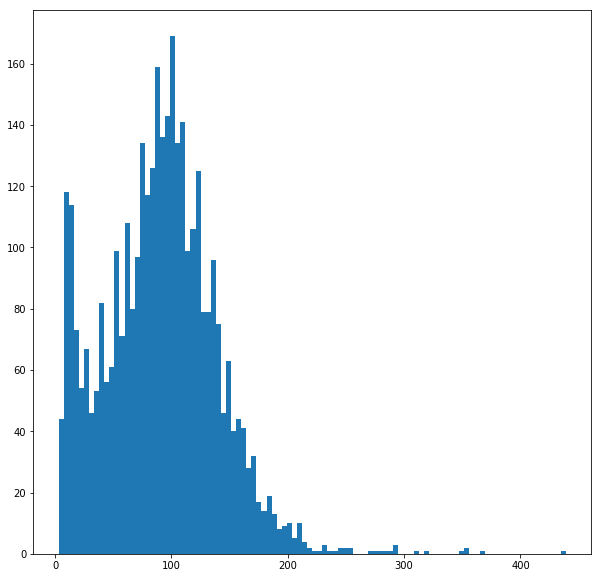

In [22]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.hist(length,bins=100)
plt.show()

In [46]:
# we can check the distribution:
dictionary_6yr.doc2bow(['tree'])

[(168, 1)]

In [45]:
lda_6yr.get_topic_terms(0)

[(168, 0.041298619004022638),
 (702, 0.016027947586980906),
 (140, 0.014891558170013213),
 (122, 0.013567037353829603),
 (620, 0.01350874076111285),
 (1497, 0.013417752449426791),
 (1595, 0.012311221867655382),
 (476, 0.011519817032102879),
 (401, 0.011227522127546789),
 (536, 0.01109819045270098)]